Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# %load /home/isajosep/.ipython/standard_imports.py
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

import isajosep_util
import os

#!echo 'import os'  >> /home/isajosep/.ipython/standard_imports.py
import matplotlib.pyplot as plt
import seaborn as sns
import isajosep_util.data_frame_plotter
sns.set_palette([v.value for v in isajosep_util.data_frame_plotter.AgilentColors])
import tqdm


In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
import os
data_root = os.path.join(os.path.expanduser('~'), 'Data/Udacity_Tensorflow')
os.chdir(data_root)

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

# Problem 1


Introduce and tune $L_2$ regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))

    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    layer_two_output_tensor = tf.nn.relu(layer_one_output_tensor)
    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    ########### new this time -- regularization (add to loss, not explicit network structure)
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Initialized


Minibatch loss at step 0: 517.104309
Minibatch accuracy: 10.9%
Validation accuracy: 26.1%
Minibatch loss at step 500: 151.219788
Minibatch accuracy: 72.7%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 87.489258
Minibatch accuracy: 79.7%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 52.816139
Minibatch accuracy: 78.9%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 31.578102
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 19.599113
Minibatch accuracy: 85.9%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 11.851415
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%

Test accuracy: 93.3%


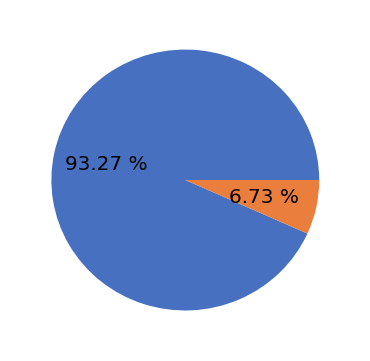

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(         test_prediction.eval(), test_labels))    
    

Good when loss is about half of the total error produced by the function ($600$ vs $250$)

Wow, even better test accuracy.... 

# Problem 2

---
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
max_num_batches = (train_labels.shape[0] - batch_size) 
print("max number of batches: {:,}".format(max_num_batches))

max number of batches: 199,872


Initialized


Minibatch loss at step 0: 600.835449
Minibatch accuracy: 6.2%
Validation accuracy: 33.5%
Minibatch loss at step 500: 145.874298
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 1000: 88.466164
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 1500: 53.650730
Minibatch accuracy: 100.0%
Validation accuracy: 63.4%
Minibatch loss at step 2000: 32.536751
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 2500: 19.732080
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 3000: 11.966666
Minibatch accuracy: 100.0%
Validation accuracy: 63.9%

Test accuracy: 70.8%


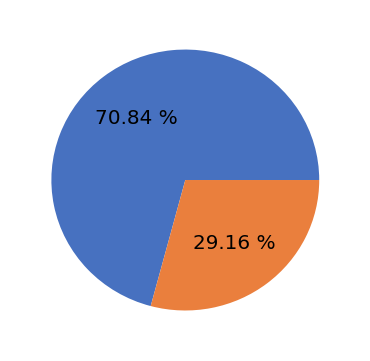

In [10]:
num_steps = 3001
batch_size = 128
num_batches = 1

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # changed -- now only three batches
        offset = (step * batch_size) % num_batches
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
        # thus, batch_data and batch_labels are subsets of this np.array. 
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}


        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))

Hm, interesting. It's still able to reduce its loss by reducing the norm of the weight matrices $\mathbf{W}$, but it's not able to make a significant impact on its validation accuracy in that manner, as it's only using one batch of size 128. 

# Problem 3

---

---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

## Graph

Hm, do I do this in the `tf.Session` or in the `tf.Graph`? `tf.Graph .`

In [11]:
batch_size = 128
dropout_keep_prob = 0.3

dropout_graph = tf.Graph()
with dropout_graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))
    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    
    # additional dropout layer
    layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(layer_one_output_tensor, keep_prob=dropout_keep_prob))

    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    # new this time -- regularization
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

## Session

Initialized


Minibatch loss at step 0: 800.659790
Minibatch accuracy: 11.7%
Validation accuracy: 30.3%
Minibatch loss at step 500: 181.967438
Minibatch accuracy: 60.2%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 92.086472
Minibatch accuracy: 68.8%
Validation accuracy: 78.0%
Minibatch loss at step 1500: 56.048244
Minibatch accuracy: 63.3%
Validation accuracy: 79.9%
Minibatch loss at step 2000: 32.467590
Minibatch accuracy: 78.9%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 20.392408
Minibatch accuracy: 74.2%
Validation accuracy: 82.8%
Minibatch loss at step 3000: 12.247711
Minibatch accuracy: 75.8%
Validation accuracy: 83.8%

Test accuracy: 90.6%


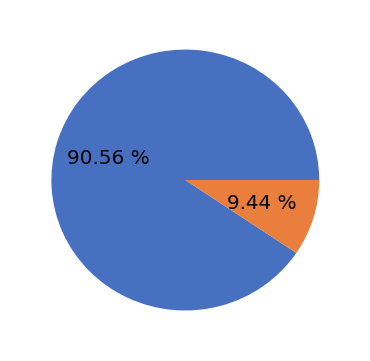

In [12]:
num_steps = 3001
batch_size = 128
num_batches = max_num_batches

with tf.Session(graph=dropout_graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % num_batches

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data.
        # thus, batch_data and batch_labels are subsets of this np.array.
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}

        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))
    isajosep_util.plot_pie_percent(
        accuracy(test_prediction.eval(), test_labels))

Hm, yes,rescued 2% using 0.7 dropout, 5% using 0.5 dropout, 8% using 0.3 dropout, 2% using 0.1 dropout.  

# Problem 4
---

---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---




Initialized


Minibatch loss at step 0: 10,550.8; Minibatch accuracy: 8.6%; Validation accuracy: 9.5%
Minibatch loss at step 500: 9,697.4; Minibatch accuracy: 10.9%; Validation accuracy: 9.5%
Minibatch loss at step 1000: 9,782.0; Minibatch accuracy: 14.1%; Validation accuracy: 9.5%
Minibatch loss at step 1500: 10,458.5; Minibatch accuracy: 7.8%; Validation accuracy: 9.5%
Minibatch loss at step 2000: 10,657.4; Minibatch accuracy: 10.9%; Validation accuracy: 9.5%
Minibatch loss at step 2500: 10,280.3; Minibatch accuracy: 11.7%; Validation accuracy: 9.5%
Test accuracy: 10.4%


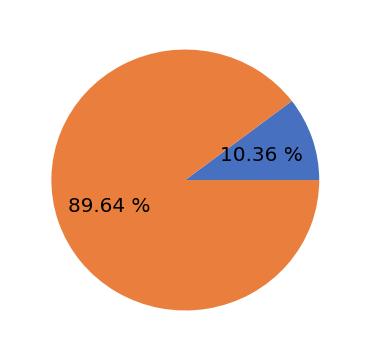

Initialized


Minibatch loss at step 0: 11,650.4; Minibatch accuracy: 7.0%; Validation accuracy: 8.4%
Minibatch loss at step 500: 10,855.3; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Minibatch loss at step 1000: 10,905.9; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Minibatch loss at step 1500: 11,279.2; Minibatch accuracy: 5.5%; Validation accuracy: 8.4%
Minibatch loss at step 2000: 11,078.8; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Minibatch loss at step 2500: 11,326.6; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Test accuracy: 8.6%


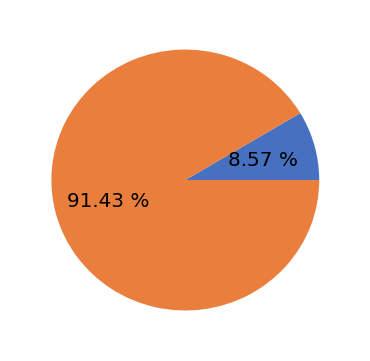

Initialized


Minibatch loss at step 0: 10,575.9; Minibatch accuracy: 6.2%; Validation accuracy: 7.9%
Minibatch loss at step 500: 11,080.0; Minibatch accuracy: 10.9%; Validation accuracy: 7.9%
Minibatch loss at step 1000: 11,573.3; Minibatch accuracy: 4.7%; Validation accuracy: 7.9%
Minibatch loss at step 1500: 12,399.0; Minibatch accuracy: 6.2%; Validation accuracy: 7.9%
Minibatch loss at step 2000: 10,880.1; Minibatch accuracy: 13.3%; Validation accuracy: 7.9%
Minibatch loss at step 2500: 10,824.0; Minibatch accuracy: 8.6%; Validation accuracy: 7.9%
Test accuracy: 8.6%


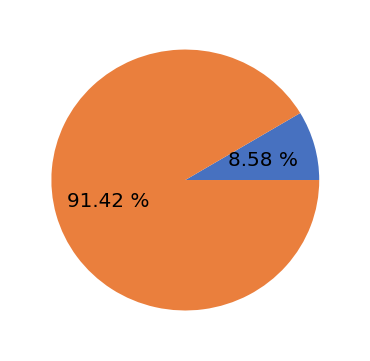

Initialized


Minibatch loss at step 0: 11,795.5; Minibatch accuracy: 9.4%; Validation accuracy: 5.5%
Minibatch loss at step 500: 12,627.5; Minibatch accuracy: 3.1%; Validation accuracy: 5.5%
Minibatch loss at step 1000: 12,577.2; Minibatch accuracy: 7.0%; Validation accuracy: 5.5%
Minibatch loss at step 1500: 12,223.4; Minibatch accuracy: 8.6%; Validation accuracy: 5.5%
Minibatch loss at step 2000: 11,801.2; Minibatch accuracy: 11.7%; Validation accuracy: 5.5%
Minibatch loss at step 2500: 13,196.8; Minibatch accuracy: 5.5%; Validation accuracy: 5.5%
Test accuracy: 5.2%


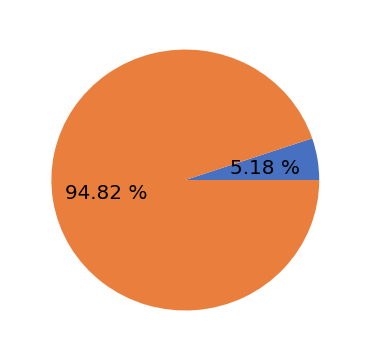

Initialized


Minibatch loss at step 0: 9,177.5; Minibatch accuracy: 7.8%; Validation accuracy: 9.0%
Minibatch loss at step 500: 10,204.5; Minibatch accuracy: 9.4%; Validation accuracy: 9.0%
Minibatch loss at step 1000: 10,235.4; Minibatch accuracy: 9.4%; Validation accuracy: 9.0%
Minibatch loss at step 1500: 9,614.9; Minibatch accuracy: 11.7%; Validation accuracy: 9.0%
Minibatch loss at step 2000: 9,831.9; Minibatch accuracy: 12.5%; Validation accuracy: 9.0%
Minibatch loss at step 2500: 10,130.4; Minibatch accuracy: 10.9%; Validation accuracy: 9.0%
Test accuracy: 9.1%


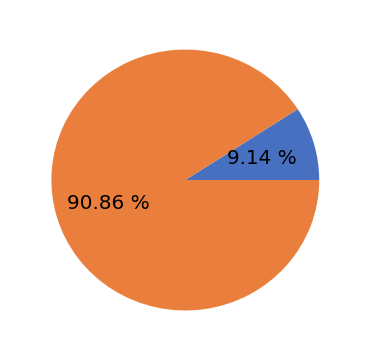

Initialized


Minibatch loss at step 0: 10,617.4; Minibatch accuracy: 7.0%; Validation accuracy: 9.3%
Minibatch loss at step 500: 10,659.6; Minibatch accuracy: 9.4%; Validation accuracy: 9.3%
Minibatch loss at step 1000: 11,078.4; Minibatch accuracy: 11.7%; Validation accuracy: 9.3%
Minibatch loss at step 1500: 10,896.5; Minibatch accuracy: 9.4%; Validation accuracy: 9.3%
Minibatch loss at step 2000: 10,458.8; Minibatch accuracy: 13.3%; Validation accuracy: 9.3%
Minibatch loss at step 2500: 11,329.5; Minibatch accuracy: 9.4%; Validation accuracy: 9.3%
Test accuracy: 9.3%


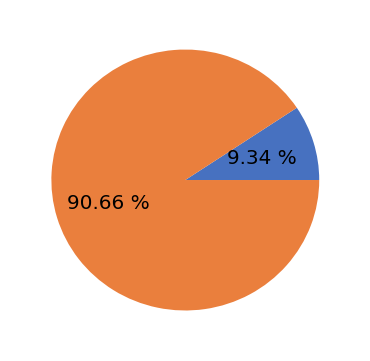

Initialized


Minibatch loss at step 0: 10,879.0; Minibatch accuracy: 10.9%; Validation accuracy: 10.6%
Minibatch loss at step 500: 9,219.6; Minibatch accuracy: 10.9%; Validation accuracy: 10.6%
Minibatch loss at step 1000: 11,003.7; Minibatch accuracy: 7.0%; Validation accuracy: 10.6%
Minibatch loss at step 1500: 10,780.9; Minibatch accuracy: 7.0%; Validation accuracy: 10.6%
Minibatch loss at step 2000: 9,880.1; Minibatch accuracy: 6.2%; Validation accuracy: 10.6%
Minibatch loss at step 2500: 10,216.4; Minibatch accuracy: 10.2%; Validation accuracy: 10.6%
Test accuracy: 11.0%


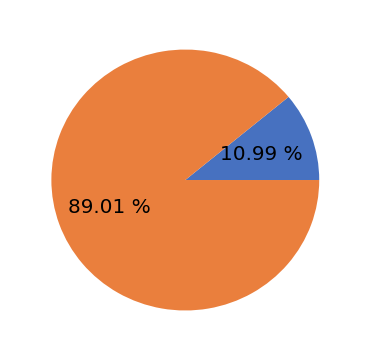

Initialized


Minibatch loss at step 0: 10,456.9; Minibatch accuracy: 11.7%; Validation accuracy: 9.5%
Minibatch loss at step 500: 10,734.4; Minibatch accuracy: 7.8%; Validation accuracy: 9.5%
Minibatch loss at step 1000: 10,207.7; Minibatch accuracy: 11.7%; Validation accuracy: 9.5%
Minibatch loss at step 1500: 11,612.8; Minibatch accuracy: 11.7%; Validation accuracy: 9.5%
Minibatch loss at step 2000: 9,883.9; Minibatch accuracy: 10.9%; Validation accuracy: 9.5%
Minibatch loss at step 2500: 10,331.0; Minibatch accuracy: 10.9%; Validation accuracy: 9.5%
Test accuracy: 9.5%


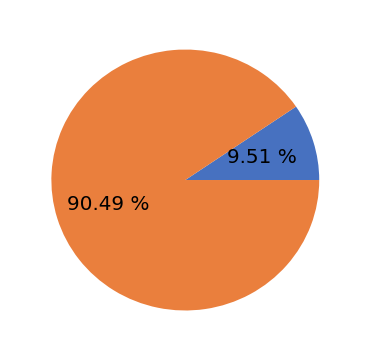

Initialized


Minibatch loss at step 0: 11,160.0; Minibatch accuracy: 9.4%; Validation accuracy: 12.0%
Minibatch loss at step 500: 10,963.8; Minibatch accuracy: 17.2%; Validation accuracy: 12.0%
Minibatch loss at step 1000: 11,713.1; Minibatch accuracy: 9.4%; Validation accuracy: 12.0%
Minibatch loss at step 1500: 10,886.9; Minibatch accuracy: 14.1%; Validation accuracy: 12.0%
Minibatch loss at step 2000: 10,299.6; Minibatch accuracy: 9.4%; Validation accuracy: 12.0%
Minibatch loss at step 2500: 11,311.5; Minibatch accuracy: 14.1%; Validation accuracy: 12.0%
Test accuracy: 12.4%


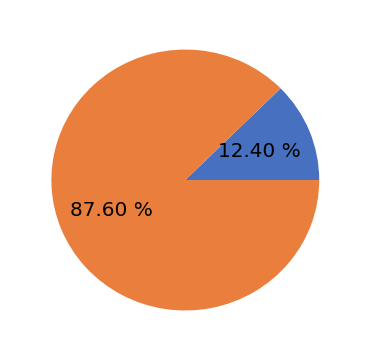

Initialized


Minibatch loss at step 0: 12,140.4; Minibatch accuracy: 3.9%; Validation accuracy: 6.9%
Minibatch loss at step 500: 10,870.3; Minibatch accuracy: 11.7%; Validation accuracy: 6.9%
Minibatch loss at step 1000: 11,661.5; Minibatch accuracy: 7.0%; Validation accuracy: 6.9%
Minibatch loss at step 1500: 10,455.0; Minibatch accuracy: 9.4%; Validation accuracy: 6.9%
Minibatch loss at step 2000: 12,171.3; Minibatch accuracy: 7.0%; Validation accuracy: 6.9%
Minibatch loss at step 2500: 10,912.9; Minibatch accuracy: 9.4%; Validation accuracy: 6.9%
Test accuracy: 5.6%


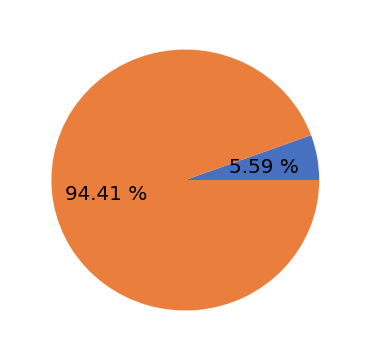

Initialized


Minibatch loss at step 0: 12,297.1; Minibatch accuracy: 6.2%; Validation accuracy: 8.5%
Minibatch loss at step 500: 11,472.6; Minibatch accuracy: 12.5%; Validation accuracy: 8.5%
Minibatch loss at step 1000: 11,781.7; Minibatch accuracy: 8.6%; Validation accuracy: 8.5%
Minibatch loss at step 1500: 10,954.8; Minibatch accuracy: 11.7%; Validation accuracy: 8.5%
Minibatch loss at step 2000: 12,032.5; Minibatch accuracy: 14.1%; Validation accuracy: 8.5%
Minibatch loss at step 2500: 11,182.4; Minibatch accuracy: 8.6%; Validation accuracy: 8.5%
Test accuracy: 8.1%


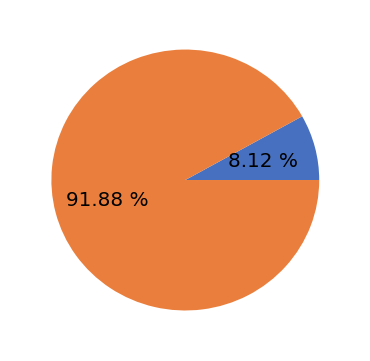

Initialized


Minibatch loss at step 0: 12,712.6; Minibatch accuracy: 7.8%; Validation accuracy: 8.9%
Minibatch loss at step 500: 12,933.8; Minibatch accuracy: 10.2%; Validation accuracy: 8.9%
Minibatch loss at step 1000: 13,479.5; Minibatch accuracy: 5.5%; Validation accuracy: 8.9%
Minibatch loss at step 1500: 12,743.9; Minibatch accuracy: 8.6%; Validation accuracy: 8.9%
Minibatch loss at step 2000: 13,535.5; Minibatch accuracy: 6.2%; Validation accuracy: 8.9%
Minibatch loss at step 2500: 12,264.5; Minibatch accuracy: 7.0%; Validation accuracy: 8.9%
Test accuracy: 8.9%


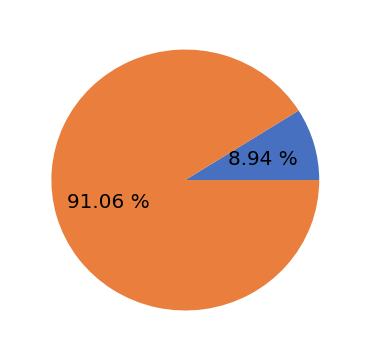

Initialized


Minibatch loss at step 0: 12,517.4; Minibatch accuracy: 9.4%; Validation accuracy: 9.3%
Minibatch loss at step 500: 12,515.2; Minibatch accuracy: 14.8%; Validation accuracy: 9.3%
Minibatch loss at step 1000: 11,790.1; Minibatch accuracy: 11.7%; Validation accuracy: 9.3%
Minibatch loss at step 1500: 11,967.4; Minibatch accuracy: 12.5%; Validation accuracy: 9.3%
Minibatch loss at step 2000: 12,693.4; Minibatch accuracy: 10.2%; Validation accuracy: 9.3%
Minibatch loss at step 2500: 11,166.0; Minibatch accuracy: 8.6%; Validation accuracy: 9.3%
Test accuracy: 9.4%


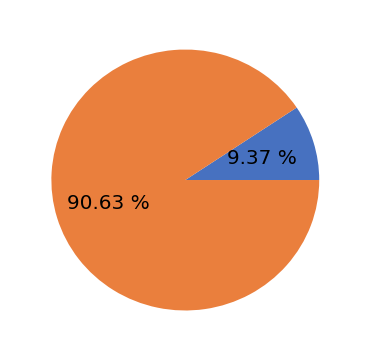

Initialized


Minibatch loss at step 0: 11,655.3; Minibatch accuracy: 16.4%; Validation accuracy: 16.8%
Minibatch loss at step 500: 10,064.8; Minibatch accuracy: 14.8%; Validation accuracy: 16.8%
Minibatch loss at step 1000: 11,411.4; Minibatch accuracy: 10.2%; Validation accuracy: 16.8%
Minibatch loss at step 1500: 9,758.7; Minibatch accuracy: 14.1%; Validation accuracy: 16.8%
Minibatch loss at step 2000: 11,274.1; Minibatch accuracy: 11.7%; Validation accuracy: 16.8%
Minibatch loss at step 2500: 10,203.4; Minibatch accuracy: 10.9%; Validation accuracy: 16.8%
Test accuracy: 17.4%


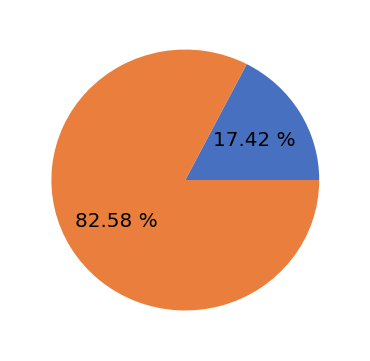

Initialized


Minibatch loss at step 0: 10,331.9; Minibatch accuracy: 13.3%; Validation accuracy: 11.0%
Minibatch loss at step 500: 10,649.7; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 1000: 9,844.6; Minibatch accuracy: 10.2%; Validation accuracy: 11.0%
Minibatch loss at step 1500: 10,493.9; Minibatch accuracy: 7.0%; Validation accuracy: 11.0%
Minibatch loss at step 2000: 10,471.0; Minibatch accuracy: 6.2%; Validation accuracy: 11.0%
Minibatch loss at step 2500: 10,995.0; Minibatch accuracy: 11.7%; Validation accuracy: 11.0%
Test accuracy: 11.6%


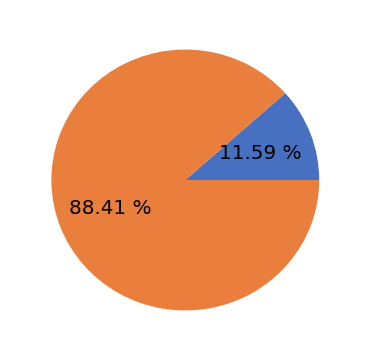

Initialized


Minibatch loss at step 0: 12,046.1; Minibatch accuracy: 7.8%; Validation accuracy: 6.1%
Minibatch loss at step 500: 11,917.1; Minibatch accuracy: 3.9%; Validation accuracy: 6.1%
Minibatch loss at step 1000: 11,705.0; Minibatch accuracy: 8.6%; Validation accuracy: 6.1%
Minibatch loss at step 1500: 11,638.5; Minibatch accuracy: 10.9%; Validation accuracy: 6.1%
Minibatch loss at step 2000: 12,609.6; Minibatch accuracy: 10.9%; Validation accuracy: 6.1%
Minibatch loss at step 2500: 11,777.3; Minibatch accuracy: 5.5%; Validation accuracy: 6.1%
Test accuracy: 5.7%


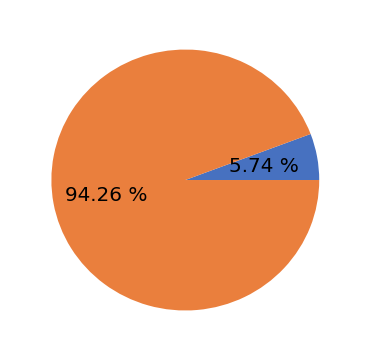

Initialized


Minibatch loss at step 0: 9,971.2; Minibatch accuracy: 13.3%; Validation accuracy: 10.7%
Minibatch loss at step 500: 9,988.7; Minibatch accuracy: 14.8%; Validation accuracy: 10.7%
Minibatch loss at step 1000: 10,055.0; Minibatch accuracy: 10.9%; Validation accuracy: 10.7%
Minibatch loss at step 1500: 10,365.7; Minibatch accuracy: 11.7%; Validation accuracy: 10.7%
Minibatch loss at step 2000: 9,498.5; Minibatch accuracy: 7.0%; Validation accuracy: 10.7%
Minibatch loss at step 2500: 10,107.2; Minibatch accuracy: 8.6%; Validation accuracy: 10.7%
Test accuracy: 10.7%


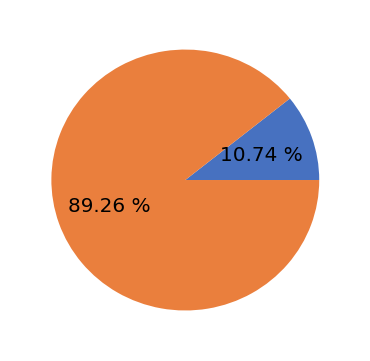

Initialized


Minibatch loss at step 0: 11,547.9; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 500: 10,570.6; Minibatch accuracy: 10.9%; Validation accuracy: 11.0%
Minibatch loss at step 1000: 11,355.3; Minibatch accuracy: 8.6%; Validation accuracy: 11.0%
Minibatch loss at step 1500: 10,713.9; Minibatch accuracy: 18.8%; Validation accuracy: 11.0%
Minibatch loss at step 2000: 11,695.5; Minibatch accuracy: 13.3%; Validation accuracy: 11.0%
Minibatch loss at step 2500: 10,503.6; Minibatch accuracy: 10.2%; Validation accuracy: 11.0%
Test accuracy: 11.7%


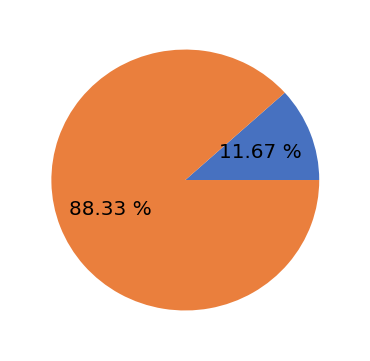

Initialized


Minibatch loss at step 0: 10,567.9; Minibatch accuracy: 7.8%; Validation accuracy: 11.1%
Minibatch loss at step 500: 11,330.5; Minibatch accuracy: 6.2%; Validation accuracy: 11.1%
Minibatch loss at step 1000: 9,919.2; Minibatch accuracy: 14.8%; Validation accuracy: 11.1%
Minibatch loss at step 1500: 11,533.5; Minibatch accuracy: 11.7%; Validation accuracy: 11.1%
Minibatch loss at step 2000: 10,251.4; Minibatch accuracy: 11.7%; Validation accuracy: 11.1%
Minibatch loss at step 2500: 11,750.2; Minibatch accuracy: 7.0%; Validation accuracy: 11.1%
Test accuracy: 11.2%


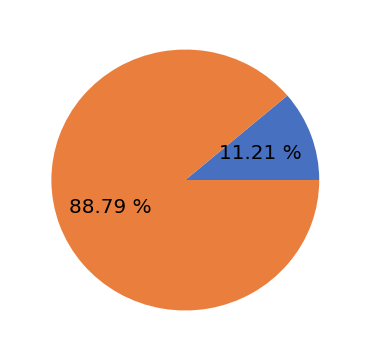

Initialized


Minibatch loss at step 0: 12,248.8; Minibatch accuracy: 10.9%; Validation accuracy: 7.7%
Minibatch loss at step 500: 11,716.7; Minibatch accuracy: 5.5%; Validation accuracy: 7.7%
Minibatch loss at step 1000: 11,886.6; Minibatch accuracy: 8.6%; Validation accuracy: 7.7%
Minibatch loss at step 1500: 12,338.0; Minibatch accuracy: 7.8%; Validation accuracy: 7.7%
Minibatch loss at step 2000: 11,052.8; Minibatch accuracy: 10.9%; Validation accuracy: 7.7%
Minibatch loss at step 2500: 11,105.5; Minibatch accuracy: 10.2%; Validation accuracy: 7.7%
Test accuracy: 7.5%


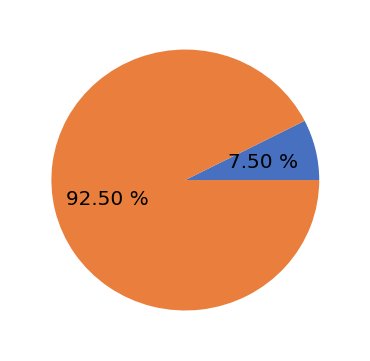

Initialized


Minibatch loss at step 0: 12,579.6; Minibatch accuracy: 3.1%; Validation accuracy: 8.4%
Minibatch loss at step 500: 11,976.8; Minibatch accuracy: 13.3%; Validation accuracy: 8.4%
Minibatch loss at step 1000: 10,430.5; Minibatch accuracy: 7.8%; Validation accuracy: 8.4%
Minibatch loss at step 1500: 11,144.1; Minibatch accuracy: 7.8%; Validation accuracy: 8.4%
Minibatch loss at step 2000: 10,911.6; Minibatch accuracy: 9.4%; Validation accuracy: 8.4%
Minibatch loss at step 2500: 10,555.4; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Test accuracy: 8.6%


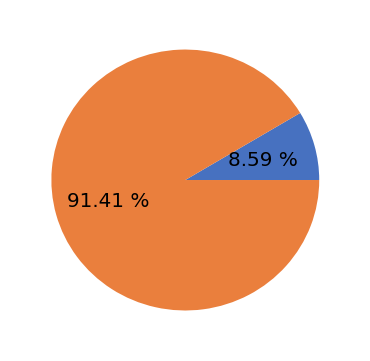

Initialized


Minibatch loss at step 0: 9,439.8; Minibatch accuracy: 19.5%; Validation accuracy: 15.5%
Minibatch loss at step 500: 8,818.4; Minibatch accuracy: 21.1%; Validation accuracy: 15.5%
Minibatch loss at step 1000: 9,308.4; Minibatch accuracy: 14.1%; Validation accuracy: 15.5%
Minibatch loss at step 1500: 9,055.5; Minibatch accuracy: 10.9%; Validation accuracy: 15.5%
Minibatch loss at step 2000: 9,419.5; Minibatch accuracy: 10.9%; Validation accuracy: 15.5%
Minibatch loss at step 2500: 9,671.0; Minibatch accuracy: 13.3%; Validation accuracy: 15.5%
Test accuracy: 16.3%


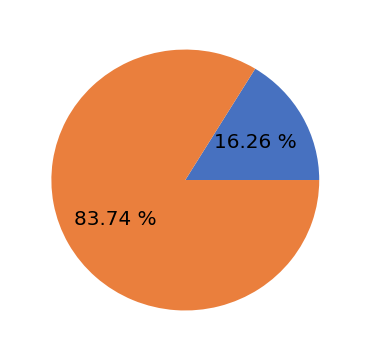

Initialized


Minibatch loss at step 0: 9,812.4; Minibatch accuracy: 13.3%; Validation accuracy: 11.4%
Minibatch loss at step 500: 9,744.3; Minibatch accuracy: 10.9%; Validation accuracy: 11.4%
Minibatch loss at step 1000: 9,648.7; Minibatch accuracy: 10.9%; Validation accuracy: 11.4%
Minibatch loss at step 1500: 10,059.8; Minibatch accuracy: 7.0%; Validation accuracy: 11.4%
Minibatch loss at step 2000: 9,444.0; Minibatch accuracy: 13.3%; Validation accuracy: 11.4%
Minibatch loss at step 2500: 10,550.2; Minibatch accuracy: 7.0%; Validation accuracy: 11.4%
Test accuracy: 10.9%


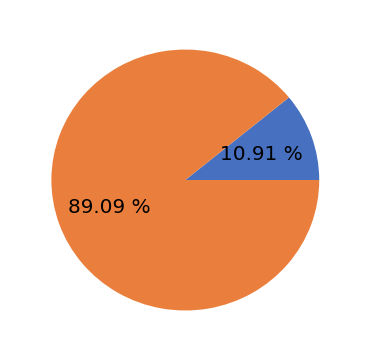

Initialized


Minibatch loss at step 0: 8,958.7; Minibatch accuracy: 14.1%; Validation accuracy: 9.1%
Minibatch loss at step 500: 10,298.8; Minibatch accuracy: 7.8%; Validation accuracy: 9.1%
Minibatch loss at step 1000: 10,008.2; Minibatch accuracy: 7.0%; Validation accuracy: 9.1%
Minibatch loss at step 1500: 9,688.6; Minibatch accuracy: 10.2%; Validation accuracy: 9.1%
Minibatch loss at step 2000: 9,792.4; Minibatch accuracy: 10.2%; Validation accuracy: 9.1%
Minibatch loss at step 2500: 9,302.5; Minibatch accuracy: 12.5%; Validation accuracy: 9.1%
Test accuracy: 8.6%


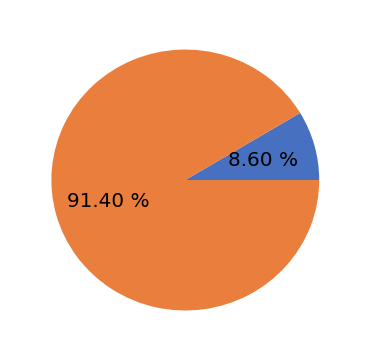

Initialized


Minibatch loss at step 0: 12,279.0; Minibatch accuracy: 6.2%; Validation accuracy: 7.3%
Minibatch loss at step 500: 11,632.5; Minibatch accuracy: 7.8%; Validation accuracy: 7.3%
Minibatch loss at step 1000: 10,256.6; Minibatch accuracy: 12.5%; Validation accuracy: 7.3%
Minibatch loss at step 1500: 12,152.4; Minibatch accuracy: 3.9%; Validation accuracy: 7.3%
Minibatch loss at step 2000: 11,110.3; Minibatch accuracy: 9.4%; Validation accuracy: 7.3%
Minibatch loss at step 2500: 11,477.0; Minibatch accuracy: 5.5%; Validation accuracy: 7.3%
Test accuracy: 7.1%


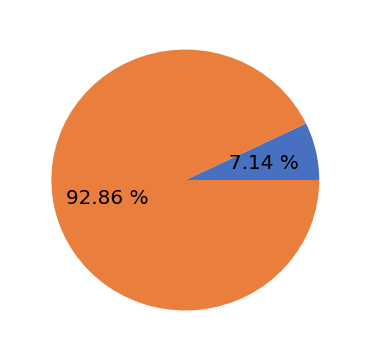

Initialized


Minibatch loss at step 0: 12,038.2; Minibatch accuracy: 10.2%; Validation accuracy: 10.0%
Minibatch loss at step 500: 11,870.3; Minibatch accuracy: 7.8%; Validation accuracy: 10.0%
Minibatch loss at step 1000: 11,271.7; Minibatch accuracy: 10.2%; Validation accuracy: 10.0%
Minibatch loss at step 1500: 12,288.5; Minibatch accuracy: 10.9%; Validation accuracy: 10.0%
Minibatch loss at step 2000: 11,823.2; Minibatch accuracy: 7.8%; Validation accuracy: 10.0%
Minibatch loss at step 2500: 11,574.6; Minibatch accuracy: 15.6%; Validation accuracy: 10.0%
Test accuracy: 10.3%


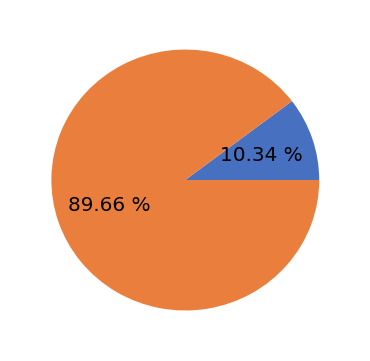

Initialized


Minibatch loss at step 0: 9,726.2; Minibatch accuracy: 14.8%; Validation accuracy: 15.7%
Minibatch loss at step 500: 10,644.3; Minibatch accuracy: 15.6%; Validation accuracy: 15.7%
Minibatch loss at step 1000: 8,937.7; Minibatch accuracy: 14.8%; Validation accuracy: 15.7%
Minibatch loss at step 1500: 9,698.4; Minibatch accuracy: 17.2%; Validation accuracy: 15.7%
Minibatch loss at step 2000: 11,407.9; Minibatch accuracy: 7.8%; Validation accuracy: 15.7%
Minibatch loss at step 2500: 11,049.7; Minibatch accuracy: 11.7%; Validation accuracy: 15.7%
Test accuracy: 15.6%


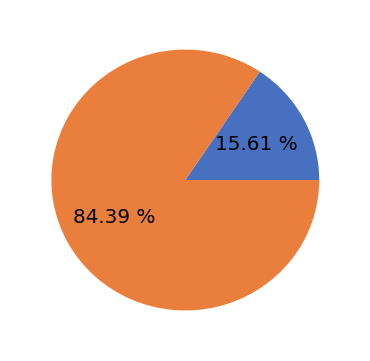

Initialized


Minibatch loss at step 0: 10,683.1; Minibatch accuracy: 11.7%; Validation accuracy: 11.9%
Minibatch loss at step 500: 9,906.0; Minibatch accuracy: 11.7%; Validation accuracy: 11.9%
Minibatch loss at step 1000: 11,244.7; Minibatch accuracy: 10.2%; Validation accuracy: 11.9%
Minibatch loss at step 1500: 10,019.6; Minibatch accuracy: 11.7%; Validation accuracy: 11.9%
Minibatch loss at step 2000: 10,451.3; Minibatch accuracy: 12.5%; Validation accuracy: 11.9%
Minibatch loss at step 2500: 11,006.7; Minibatch accuracy: 9.4%; Validation accuracy: 11.9%
Test accuracy: 12.4%


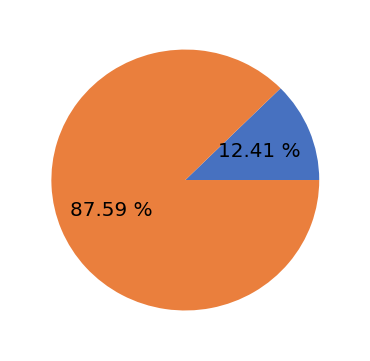

Initialized


Minibatch loss at step 0: 11,368.8; Minibatch accuracy: 7.0%; Validation accuracy: 8.4%
Minibatch loss at step 500: 11,719.4; Minibatch accuracy: 12.5%; Validation accuracy: 8.4%
Minibatch loss at step 1000: 9,910.7; Minibatch accuracy: 16.4%; Validation accuracy: 8.4%
Minibatch loss at step 1500: 10,589.8; Minibatch accuracy: 11.7%; Validation accuracy: 8.4%
Minibatch loss at step 2000: 11,984.1; Minibatch accuracy: 7.0%; Validation accuracy: 8.4%
Minibatch loss at step 2500: 11,074.2; Minibatch accuracy: 8.6%; Validation accuracy: 8.4%
Test accuracy: 8.4%


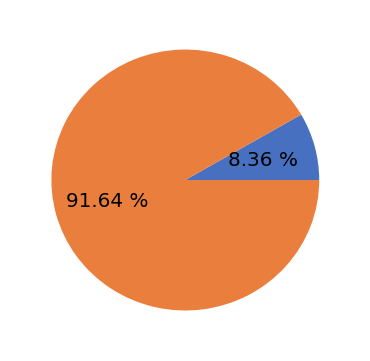

Initialized


Minibatch loss at step 0: 10,616.6; Minibatch accuracy: 7.8%; Validation accuracy: 9.4%
Minibatch loss at step 500: 9,494.4; Minibatch accuracy: 11.7%; Validation accuracy: 9.4%
Minibatch loss at step 1000: 10,757.2; Minibatch accuracy: 6.2%; Validation accuracy: 9.4%
Minibatch loss at step 1500: 10,888.4; Minibatch accuracy: 9.4%; Validation accuracy: 9.4%
Minibatch loss at step 2000: 11,947.5; Minibatch accuracy: 10.2%; Validation accuracy: 9.4%
Minibatch loss at step 2500: 11,334.8; Minibatch accuracy: 6.2%; Validation accuracy: 9.4%
Test accuracy: 9.2%


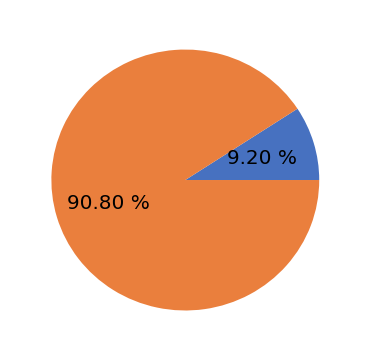

Initialized


Minibatch loss at step 0: 12,254.1; Minibatch accuracy: 3.9%; Validation accuracy: 5.1%
Minibatch loss at step 500: 13,486.7; Minibatch accuracy: 7.0%; Validation accuracy: 5.1%
Minibatch loss at step 1000: 11,651.7; Minibatch accuracy: 9.4%; Validation accuracy: 5.1%
Minibatch loss at step 1500: 12,897.5; Minibatch accuracy: 7.8%; Validation accuracy: 5.1%
Minibatch loss at step 2000: 12,453.7; Minibatch accuracy: 7.0%; Validation accuracy: 5.1%
Minibatch loss at step 2500: 13,404.9; Minibatch accuracy: 6.2%; Validation accuracy: 5.1%
Test accuracy: 4.6%


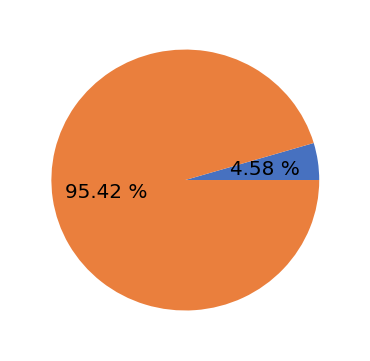

Initialized


Minibatch loss at step 0: 11,064.0; Minibatch accuracy: 5.5%; Validation accuracy: 7.3%
Minibatch loss at step 500: 11,332.4; Minibatch accuracy: 6.2%; Validation accuracy: 7.3%
Minibatch loss at step 1000: 11,975.3; Minibatch accuracy: 7.0%; Validation accuracy: 7.3%
Minibatch loss at step 1500: 10,205.0; Minibatch accuracy: 7.0%; Validation accuracy: 7.3%
Minibatch loss at step 2000: 10,963.6; Minibatch accuracy: 7.8%; Validation accuracy: 7.3%
Minibatch loss at step 2500: 11,430.7; Minibatch accuracy: 6.2%; Validation accuracy: 7.3%
Test accuracy: 7.1%


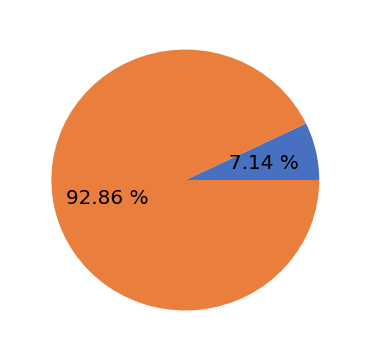

Initialized


Minibatch loss at step 0: 12,884.0; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 500: 14,053.3; Minibatch accuracy: 5.5%; Validation accuracy: 11.0%
Minibatch loss at step 1000: 12,197.4; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 1500: 12,634.8; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 2000: 12,405.1; Minibatch accuracy: 9.4%; Validation accuracy: 11.0%
Minibatch loss at step 2500: 13,034.7; Minibatch accuracy: 6.2%; Validation accuracy: 11.0%
Test accuracy: 11.5%


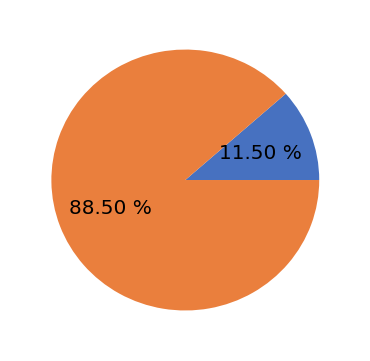

Initialized


Minibatch loss at step 0: 11,002.9; Minibatch accuracy: 10.2%; Validation accuracy: 6.1%
Minibatch loss at step 500: 11,006.6; Minibatch accuracy: 5.5%; Validation accuracy: 6.1%
Minibatch loss at step 1000: 10,409.5; Minibatch accuracy: 11.7%; Validation accuracy: 6.1%
Minibatch loss at step 1500: 10,651.8; Minibatch accuracy: 7.8%; Validation accuracy: 6.1%
Minibatch loss at step 2000: 11,323.1; Minibatch accuracy: 5.5%; Validation accuracy: 6.1%
Minibatch loss at step 2500: 10,729.2; Minibatch accuracy: 8.6%; Validation accuracy: 6.1%
Test accuracy: 6.0%


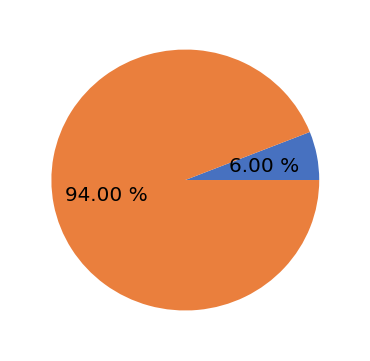

Initialized


Minibatch loss at step 0: 11,734.2; Minibatch accuracy: 9.4%; Validation accuracy: 8.9%
Minibatch loss at step 500: 12,319.1; Minibatch accuracy: 9.4%; Validation accuracy: 8.9%
Minibatch loss at step 1000: 12,447.7; Minibatch accuracy: 11.7%; Validation accuracy: 8.9%
Minibatch loss at step 1500: 12,321.7; Minibatch accuracy: 10.2%; Validation accuracy: 8.9%
Minibatch loss at step 2000: 13,887.4; Minibatch accuracy: 8.6%; Validation accuracy: 8.9%
Minibatch loss at step 2500: 12,640.0; Minibatch accuracy: 9.4%; Validation accuracy: 8.9%
Test accuracy: 9.1%


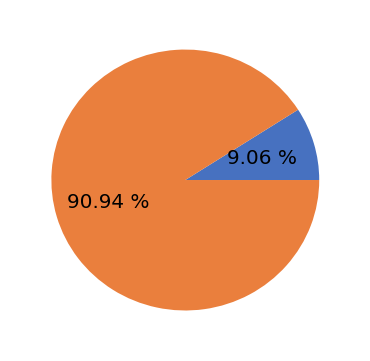

Initialized


Minibatch loss at step 0: 9,752.5; Minibatch accuracy: 12.5%; Validation accuracy: 12.1%
Minibatch loss at step 500: 11,894.0; Minibatch accuracy: 10.2%; Validation accuracy: 12.1%
Minibatch loss at step 1000: 10,154.8; Minibatch accuracy: 20.3%; Validation accuracy: 12.1%
Minibatch loss at step 1500: 10,900.8; Minibatch accuracy: 10.2%; Validation accuracy: 12.1%
Minibatch loss at step 2000: 11,176.7; Minibatch accuracy: 10.9%; Validation accuracy: 12.1%
Minibatch loss at step 2500: 11,172.1; Minibatch accuracy: 8.6%; Validation accuracy: 12.1%
Test accuracy: 11.7%


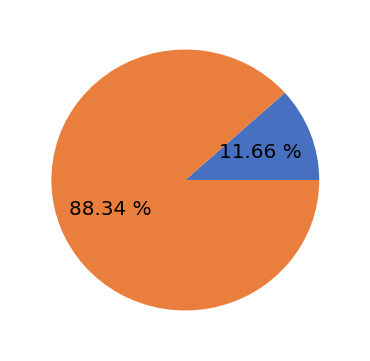

Initialized


Minibatch loss at step 0: 10,875.7; Minibatch accuracy: 13.3%; Validation accuracy: 6.0%
Minibatch loss at step 500: 10,841.6; Minibatch accuracy: 6.2%; Validation accuracy: 6.0%
Minibatch loss at step 1000: 10,726.6; Minibatch accuracy: 11.7%; Validation accuracy: 6.0%
Minibatch loss at step 1500: 10,427.4; Minibatch accuracy: 10.9%; Validation accuracy: 6.0%
Minibatch loss at step 2000: 10,753.3; Minibatch accuracy: 10.2%; Validation accuracy: 6.0%
Minibatch loss at step 2500: 10,026.4; Minibatch accuracy: 8.6%; Validation accuracy: 6.0%
Test accuracy: 5.2%


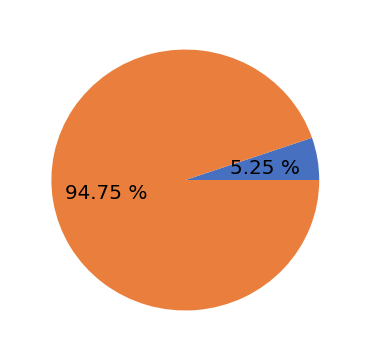

Initialized


Minibatch loss at step 0: 9,732.3; Minibatch accuracy: 12.5%; Validation accuracy: 9.7%
Minibatch loss at step 500: 10,068.6; Minibatch accuracy: 9.4%; Validation accuracy: 9.7%
Minibatch loss at step 1000: 9,780.8; Minibatch accuracy: 12.5%; Validation accuracy: 9.7%
Minibatch loss at step 1500: 8,939.5; Minibatch accuracy: 14.1%; Validation accuracy: 9.7%
Minibatch loss at step 2000: 10,024.6; Minibatch accuracy: 7.8%; Validation accuracy: 9.7%
Minibatch loss at step 2500: 9,716.3; Minibatch accuracy: 13.3%; Validation accuracy: 9.7%
Test accuracy: 10.4%


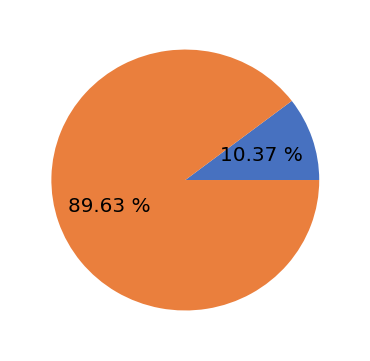

Initialized


Minibatch loss at step 0: 12,902.1; Minibatch accuracy: 11.7%; Validation accuracy: 9.8%
Minibatch loss at step 500: 13,012.5; Minibatch accuracy: 7.0%; Validation accuracy: 9.8%
Minibatch loss at step 1000: 12,393.8; Minibatch accuracy: 7.0%; Validation accuracy: 9.8%
Minibatch loss at step 1500: 12,425.2; Minibatch accuracy: 10.2%; Validation accuracy: 9.8%
Minibatch loss at step 2000: 12,925.1; Minibatch accuracy: 4.7%; Validation accuracy: 9.8%
Minibatch loss at step 2500: 12,613.2; Minibatch accuracy: 14.8%; Validation accuracy: 9.8%
Test accuracy: 10.1%


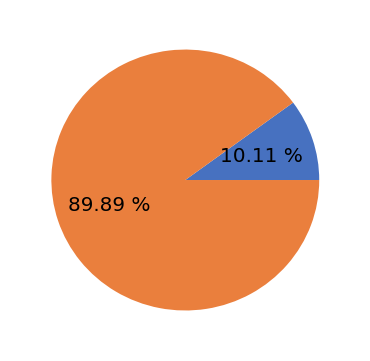

Initialized


Minibatch loss at step 0: 10,922.9; Minibatch accuracy: 10.2%; Validation accuracy: 12.9%
Minibatch loss at step 500: 9,002.6; Minibatch accuracy: 21.9%; Validation accuracy: 12.9%
Minibatch loss at step 1000: 9,907.6; Minibatch accuracy: 10.9%; Validation accuracy: 12.9%
Minibatch loss at step 1500: 10,563.6; Minibatch accuracy: 12.5%; Validation accuracy: 13.0%
Minibatch loss at step 2000: 9,582.8; Minibatch accuracy: 18.8%; Validation accuracy: 13.0%
Minibatch loss at step 2500: 10,586.3; Minibatch accuracy: 10.2%; Validation accuracy: 13.0%
Test accuracy: 13.4%


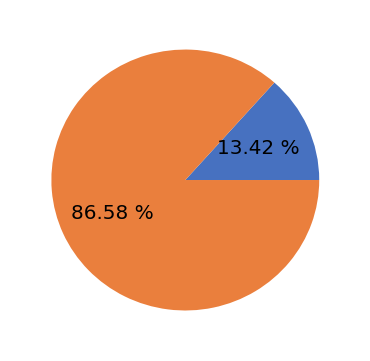

Initialized


Minibatch loss at step 0: 13,246.0; Minibatch accuracy: 2.3%; Validation accuracy: 8.8%
Minibatch loss at step 500: 11,195.6; Minibatch accuracy: 9.4%; Validation accuracy: 8.8%
Minibatch loss at step 1000: 11,881.2; Minibatch accuracy: 10.9%; Validation accuracy: 8.8%
Minibatch loss at step 1500: 12,560.4; Minibatch accuracy: 9.4%; Validation accuracy: 8.8%
Minibatch loss at step 2000: 12,103.7; Minibatch accuracy: 7.0%; Validation accuracy: 8.8%
Minibatch loss at step 2500: 10,922.3; Minibatch accuracy: 10.2%; Validation accuracy: 8.8%
Test accuracy: 8.3%


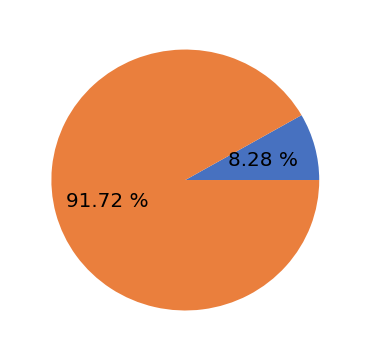

Initialized


Minibatch loss at step 0: 9,955.7; Minibatch accuracy: 12.5%; Validation accuracy: 10.3%
Minibatch loss at step 500: 10,458.7; Minibatch accuracy: 10.2%; Validation accuracy: 10.4%
Minibatch loss at step 1000: 11,219.0; Minibatch accuracy: 8.6%; Validation accuracy: 10.4%
Minibatch loss at step 1500: 10,320.5; Minibatch accuracy: 12.5%; Validation accuracy: 10.4%
Minibatch loss at step 2000: 9,232.3; Minibatch accuracy: 13.3%; Validation accuracy: 10.4%
Minibatch loss at step 2500: 11,816.2; Minibatch accuracy: 9.4%; Validation accuracy: 10.4%
Test accuracy: 11.5%


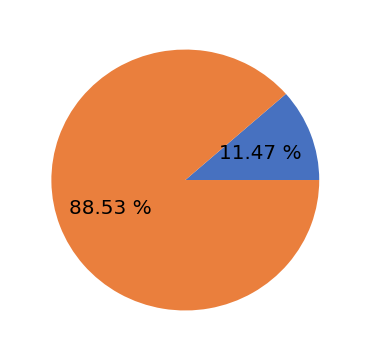

Initialized


Minibatch loss at step 0: 11,769.6; Minibatch accuracy: 7.0%; Validation accuracy: 10.2%
Minibatch loss at step 500: 10,898.8; Minibatch accuracy: 11.7%; Validation accuracy: 10.2%
Minibatch loss at step 1000: 11,007.5; Minibatch accuracy: 11.7%; Validation accuracy: 10.2%
Minibatch loss at step 1500: 11,531.0; Minibatch accuracy: 7.8%; Validation accuracy: 10.2%
Minibatch loss at step 2000: 11,076.7; Minibatch accuracy: 6.2%; Validation accuracy: 10.2%
Minibatch loss at step 2500: 11,989.6; Minibatch accuracy: 11.7%; Validation accuracy: 10.2%
Test accuracy: 10.2%


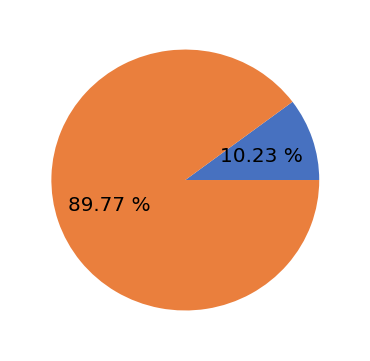

Initialized


Minibatch loss at step 0: 9,708.2; Minibatch accuracy: 9.4%; Validation accuracy: 11.3%
Minibatch loss at step 500: 9,894.6; Minibatch accuracy: 12.5%; Validation accuracy: 11.3%
Minibatch loss at step 1000: 9,262.3; Minibatch accuracy: 15.6%; Validation accuracy: 11.3%
Minibatch loss at step 1500: 11,163.1; Minibatch accuracy: 7.8%; Validation accuracy: 11.3%
Minibatch loss at step 2000: 10,988.2; Minibatch accuracy: 13.3%; Validation accuracy: 11.3%
Minibatch loss at step 2500: 9,812.9; Minibatch accuracy: 10.2%; Validation accuracy: 11.3%
Test accuracy: 11.3%


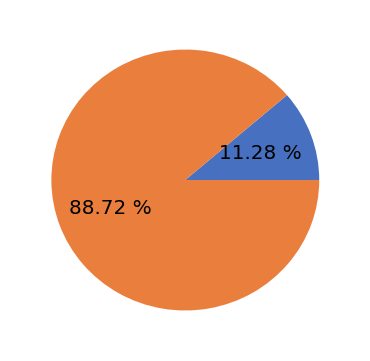

Initialized


Minibatch loss at step 0: 11,007.8; Minibatch accuracy: 12.5%; Validation accuracy: 12.7%
Minibatch loss at step 500: 9,721.7; Minibatch accuracy: 14.1%; Validation accuracy: 12.7%
Minibatch loss at step 1000: 10,141.1; Minibatch accuracy: 10.9%; Validation accuracy: 12.8%
Minibatch loss at step 1500: 10,063.8; Minibatch accuracy: 11.7%; Validation accuracy: 12.8%
Minibatch loss at step 2000: 10,805.9; Minibatch accuracy: 9.4%; Validation accuracy: 12.8%
Minibatch loss at step 2500: 10,596.8; Minibatch accuracy: 10.9%; Validation accuracy: 12.8%
Test accuracy: 13.3%


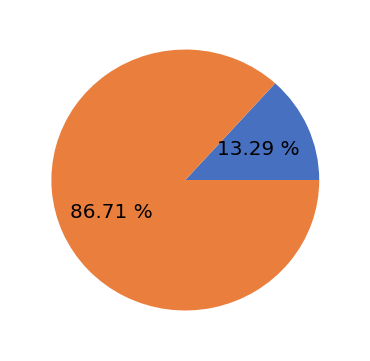

Initialized


Minibatch loss at step 0: 11,226.7; Minibatch accuracy: 7.8%; Validation accuracy: 8.7%
Minibatch loss at step 500: 11,087.6; Minibatch accuracy: 7.8%; Validation accuracy: 8.7%
Minibatch loss at step 1000: 11,144.5; Minibatch accuracy: 12.5%; Validation accuracy: 8.8%
Minibatch loss at step 1500: 10,076.5; Minibatch accuracy: 7.8%; Validation accuracy: 8.8%
Minibatch loss at step 2000: 11,834.0; Minibatch accuracy: 8.6%; Validation accuracy: 8.8%
Minibatch loss at step 2500: 11,058.1; Minibatch accuracy: 9.4%; Validation accuracy: 8.8%
Test accuracy: 9.1%


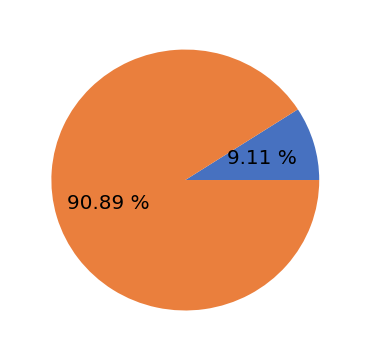

Initialized


Minibatch loss at step 0: 9,592.9; Minibatch accuracy: 13.3%; Validation accuracy: 10.8%
Minibatch loss at step 500: 10,133.9; Minibatch accuracy: 8.6%; Validation accuracy: 10.8%
Minibatch loss at step 1000: 10,496.4; Minibatch accuracy: 11.7%; Validation accuracy: 10.9%
Minibatch loss at step 1500: 10,834.2; Minibatch accuracy: 10.9%; Validation accuracy: 10.9%
Minibatch loss at step 2000: 10,254.3; Minibatch accuracy: 10.2%; Validation accuracy: 10.9%
Minibatch loss at step 2500: 9,538.9; Minibatch accuracy: 10.9%; Validation accuracy: 10.9%
Test accuracy: 10.1%


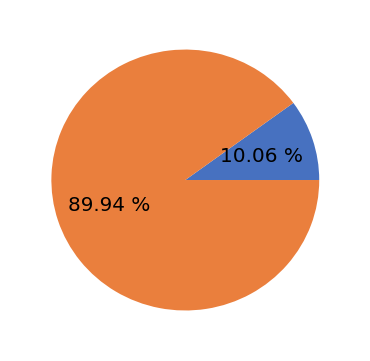

Initialized


Minibatch loss at step 0: 11,057.2; Minibatch accuracy: 10.9%; Validation accuracy: 11.2%
Minibatch loss at step 500: 11,108.4; Minibatch accuracy: 14.1%; Validation accuracy: 11.2%
Minibatch loss at step 1000: 10,583.4; Minibatch accuracy: 10.9%; Validation accuracy: 11.2%
Minibatch loss at step 1500: 11,376.6; Minibatch accuracy: 5.5%; Validation accuracy: 11.2%
Minibatch loss at step 2000: 10,806.0; Minibatch accuracy: 7.8%; Validation accuracy: 11.2%
Minibatch loss at step 2500: 10,307.4; Minibatch accuracy: 18.0%; Validation accuracy: 11.2%
Test accuracy: 11.5%


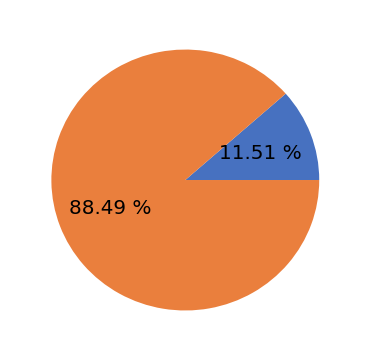

Initialized


Minibatch loss at step 0: 10,771.8; Minibatch accuracy: 10.9%; Validation accuracy: 13.1%
Minibatch loss at step 500: 11,431.5; Minibatch accuracy: 9.4%; Validation accuracy: 13.2%
Minibatch loss at step 1000: 9,666.5; Minibatch accuracy: 10.2%; Validation accuracy: 13.2%
Minibatch loss at step 1500: 10,713.3; Minibatch accuracy: 9.4%; Validation accuracy: 13.2%
Minibatch loss at step 2000: 10,986.3; Minibatch accuracy: 11.7%; Validation accuracy: 13.2%
Minibatch loss at step 2500: 9,536.1; Minibatch accuracy: 11.7%; Validation accuracy: 13.2%
Test accuracy: 13.6%


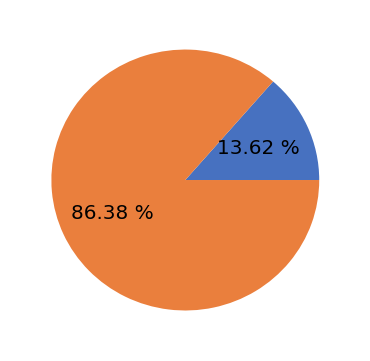

Initialized


Minibatch loss at step 0: 10,570.9; Minibatch accuracy: 11.7%; Validation accuracy: 9.9%
Minibatch loss at step 500: 12,812.4; Minibatch accuracy: 4.7%; Validation accuracy: 10.0%
Minibatch loss at step 1000: 11,362.5; Minibatch accuracy: 8.6%; Validation accuracy: 10.0%
Minibatch loss at step 1500: 11,132.7; Minibatch accuracy: 10.2%; Validation accuracy: 10.0%
Minibatch loss at step 2000: 11,825.0; Minibatch accuracy: 7.8%; Validation accuracy: 10.0%
Minibatch loss at step 2500: 11,380.0; Minibatch accuracy: 9.4%; Validation accuracy: 10.1%
Test accuracy: 10.2%


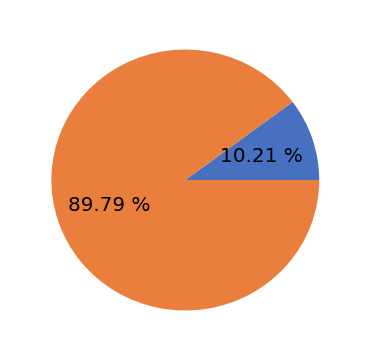

Initialized


Minibatch loss at step 0: 11,155.0; Minibatch accuracy: 9.4%; Validation accuracy: 9.9%
Minibatch loss at step 500: 9,809.6; Minibatch accuracy: 7.0%; Validation accuracy: 10.0%
Minibatch loss at step 1000: 10,576.3; Minibatch accuracy: 6.2%; Validation accuracy: 10.0%
Minibatch loss at step 1500: 11,318.0; Minibatch accuracy: 7.8%; Validation accuracy: 10.0%
Minibatch loss at step 2000: 9,425.9; Minibatch accuracy: 10.2%; Validation accuracy: 10.0%
Minibatch loss at step 2500: 8,629.9; Minibatch accuracy: 14.8%; Validation accuracy: 10.0%
Test accuracy: 10.4%


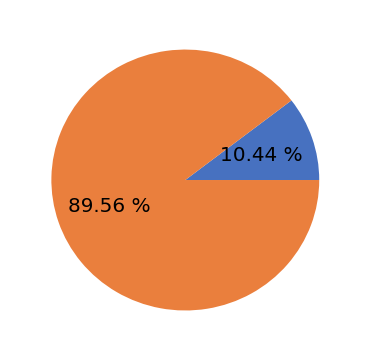

Initialized


Minibatch loss at step 0: 11,025.5; Minibatch accuracy: 8.6%; Validation accuracy: 10.5%
Minibatch loss at step 500: 9,048.5; Minibatch accuracy: 8.6%; Validation accuracy: 10.6%
Minibatch loss at step 1000: 11,342.6; Minibatch accuracy: 6.2%; Validation accuracy: 10.6%
Minibatch loss at step 1500: 9,696.8; Minibatch accuracy: 8.6%; Validation accuracy: 10.7%
Minibatch loss at step 2000: 10,597.8; Minibatch accuracy: 9.4%; Validation accuracy: 10.7%
Minibatch loss at step 2500: 10,780.4; Minibatch accuracy: 10.2%; Validation accuracy: 10.7%
Test accuracy: 9.9%


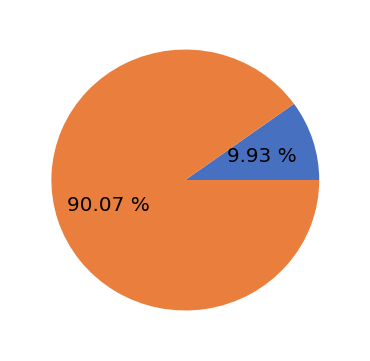

Initialized


Minibatch loss at step 0: 9,814.9; Minibatch accuracy: 6.2%; Validation accuracy: 8.6%
Minibatch loss at step 500: 10,485.8; Minibatch accuracy: 10.9%; Validation accuracy: 8.7%
Minibatch loss at step 1000: 11,875.8; Minibatch accuracy: 8.6%; Validation accuracy: 8.7%
Minibatch loss at step 1500: 11,200.9; Minibatch accuracy: 11.7%; Validation accuracy: 8.7%
Minibatch loss at step 2000: 10,665.1; Minibatch accuracy: 8.6%; Validation accuracy: 8.7%
Minibatch loss at step 2500: 10,755.3; Minibatch accuracy: 14.8%; Validation accuracy: 8.7%
Test accuracy: 8.0%


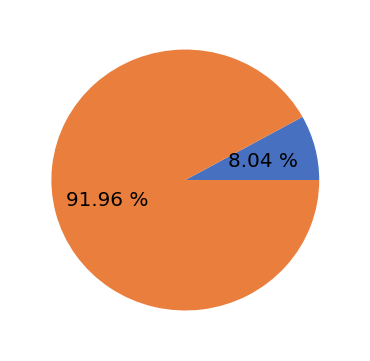

Initialized


Minibatch loss at step 0: 12,398.7; Minibatch accuracy: 7.8%; Validation accuracy: 9.9%
Minibatch loss at step 500: 13,055.3; Minibatch accuracy: 4.7%; Validation accuracy: 10.0%
Minibatch loss at step 1000: 11,944.5; Minibatch accuracy: 9.4%; Validation accuracy: 10.0%
Minibatch loss at step 1500: 13,027.4; Minibatch accuracy: 5.5%; Validation accuracy: 10.0%
Minibatch loss at step 2000: 13,513.6; Minibatch accuracy: 4.7%; Validation accuracy: 10.1%
Minibatch loss at step 2500: 12,109.8; Minibatch accuracy: 11.7%; Validation accuracy: 10.1%
Test accuracy: 10.4%


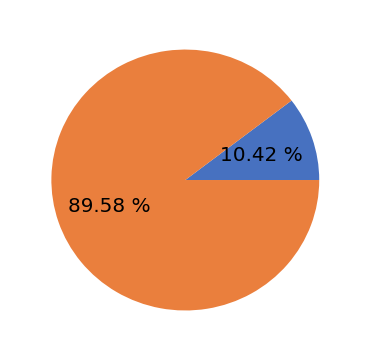

Initialized


Minibatch loss at step 0: 9,781.3; Minibatch accuracy: 11.7%; Validation accuracy: 14.2%
Minibatch loss at step 500: 9,624.1; Minibatch accuracy: 15.6%; Validation accuracy: 14.2%
Minibatch loss at step 1000: 10,126.5; Minibatch accuracy: 12.5%; Validation accuracy: 14.2%
Minibatch loss at step 1500: 10,159.3; Minibatch accuracy: 11.7%; Validation accuracy: 14.3%
Minibatch loss at step 2000: 10,275.5; Minibatch accuracy: 7.8%; Validation accuracy: 14.3%
Minibatch loss at step 2500: 10,217.4; Minibatch accuracy: 16.4%; Validation accuracy: 14.3%
Test accuracy: 15.5%


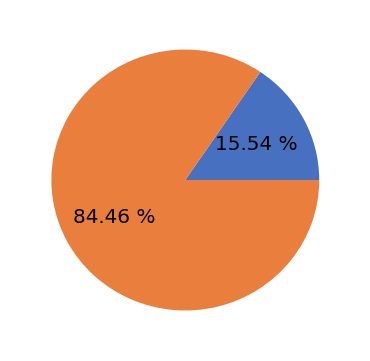

Initialized


Minibatch loss at step 0: 11,486.9; Minibatch accuracy: 10.9%; Validation accuracy: 12.1%
Minibatch loss at step 500: 11,936.9; Minibatch accuracy: 5.5%; Validation accuracy: 12.2%
Minibatch loss at step 1000: 10,309.4; Minibatch accuracy: 10.9%; Validation accuracy: 12.2%
Minibatch loss at step 1500: 10,802.9; Minibatch accuracy: 10.9%; Validation accuracy: 12.2%
Minibatch loss at step 2000: 11,151.9; Minibatch accuracy: 10.9%; Validation accuracy: 12.2%
Minibatch loss at step 2500: 11,478.8; Minibatch accuracy: 6.2%; Validation accuracy: 12.2%
Test accuracy: 12.3%


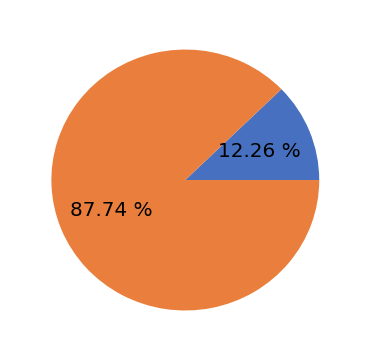

Initialized


Minibatch loss at step 0: 12,232.0; Minibatch accuracy: 11.7%; Validation accuracy: 8.8%
Minibatch loss at step 500: 12,125.1; Minibatch accuracy: 13.3%; Validation accuracy: 8.9%
Minibatch loss at step 1000: 11,568.8; Minibatch accuracy: 12.5%; Validation accuracy: 8.9%
Minibatch loss at step 1500: 11,768.6; Minibatch accuracy: 10.2%; Validation accuracy: 9.0%
Minibatch loss at step 2000: 11,495.2; Minibatch accuracy: 7.0%; Validation accuracy: 9.0%
Minibatch loss at step 2500: 11,047.7; Minibatch accuracy: 11.7%; Validation accuracy: 9.0%
Test accuracy: 8.9%


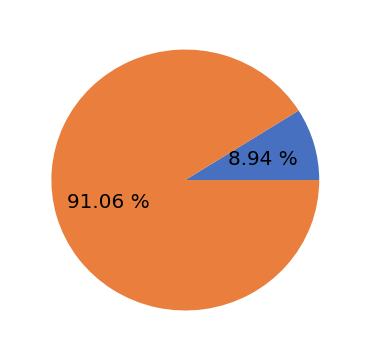

Initialized


Minibatch loss at step 0: 11,567.9; Minibatch accuracy: 7.8%; Validation accuracy: 9.2%
Minibatch loss at step 500: 11,399.7; Minibatch accuracy: 9.4%; Validation accuracy: 9.5%
Minibatch loss at step 1000: 11,534.4; Minibatch accuracy: 10.9%; Validation accuracy: 9.6%
Minibatch loss at step 1500: 12,248.6; Minibatch accuracy: 10.9%; Validation accuracy: 9.7%
Minibatch loss at step 2000: 12,073.4; Minibatch accuracy: 7.8%; Validation accuracy: 9.7%
Minibatch loss at step 2500: 10,786.4; Minibatch accuracy: 12.5%; Validation accuracy: 9.8%
Test accuracy: 9.3%


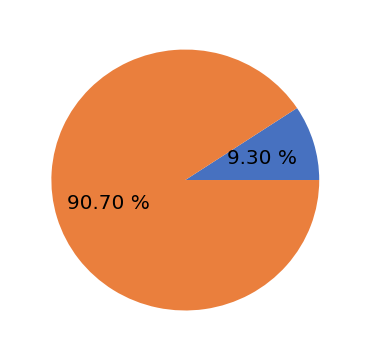

Initialized


Minibatch loss at step 0: 11,846.2; Minibatch accuracy: 7.0%; Validation accuracy: 16.3%
Minibatch loss at step 500: 11,084.8; Minibatch accuracy: 14.8%; Validation accuracy: 16.4%
Minibatch loss at step 1000: 10,154.2; Minibatch accuracy: 15.6%; Validation accuracy: 16.5%
Minibatch loss at step 1500: 10,976.8; Minibatch accuracy: 16.4%; Validation accuracy: 16.5%
Minibatch loss at step 2000: 10,775.3; Minibatch accuracy: 10.9%; Validation accuracy: 16.6%
Minibatch loss at step 2500: 10,265.7; Minibatch accuracy: 14.8%; Validation accuracy: 16.6%
Test accuracy: 17.6%


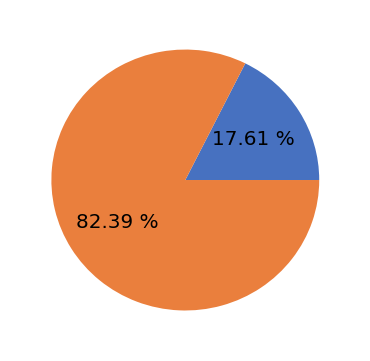

Initialized


Minibatch loss at step 0: 10,336.8; Minibatch accuracy: 8.6%; Validation accuracy: 12.1%
Minibatch loss at step 500: 10,910.8; Minibatch accuracy: 11.7%; Validation accuracy: 12.1%
Minibatch loss at step 1000: 11,653.3; Minibatch accuracy: 10.2%; Validation accuracy: 12.2%
Minibatch loss at step 1500: 10,323.1; Minibatch accuracy: 14.8%; Validation accuracy: 12.2%
Minibatch loss at step 2000: 11,991.6; Minibatch accuracy: 8.6%; Validation accuracy: 12.2%
Minibatch loss at step 2500: 9,890.7; Minibatch accuracy: 14.1%; Validation accuracy: 12.2%
Test accuracy: 12.5%


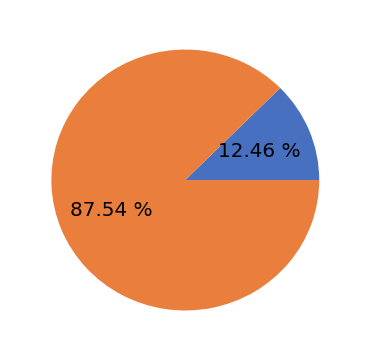

Initialized


Minibatch loss at step 0: 12,188.7; Minibatch accuracy: 10.2%; Validation accuracy: 11.0%
Minibatch loss at step 500: 11,652.8; Minibatch accuracy: 12.5%; Validation accuracy: 11.3%
Minibatch loss at step 1000: 12,489.0; Minibatch accuracy: 12.5%; Validation accuracy: 11.4%
Minibatch loss at step 1500: 11,312.1; Minibatch accuracy: 10.2%; Validation accuracy: 11.5%
Minibatch loss at step 2000: 12,964.9; Minibatch accuracy: 8.6%; Validation accuracy: 11.5%
Minibatch loss at step 2500: 11,093.3; Minibatch accuracy: 8.6%; Validation accuracy: 11.5%
Test accuracy: 11.6%


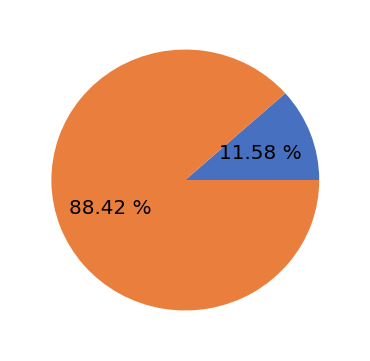

Initialized


Minibatch loss at step 0: 11,070.0; Minibatch accuracy: 13.3%; Validation accuracy: 11.8%
Minibatch loss at step 500: 10,175.2; Minibatch accuracy: 13.3%; Validation accuracy: 11.8%
Minibatch loss at step 1000: 11,442.7; Minibatch accuracy: 7.0%; Validation accuracy: 11.8%
Minibatch loss at step 1500: 9,912.8; Minibatch accuracy: 15.6%; Validation accuracy: 12.0%
Minibatch loss at step 2000: 10,559.3; Minibatch accuracy: 10.9%; Validation accuracy: 12.0%
Minibatch loss at step 2500: 9,834.2; Minibatch accuracy: 10.2%; Validation accuracy: 12.0%
Test accuracy: 12.9%


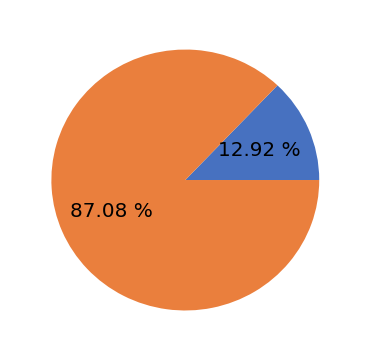

Initialized


Minibatch loss at step 0: 9,751.9; Minibatch accuracy: 13.3%; Validation accuracy: 14.4%
Minibatch loss at step 500: 7,723.4; Minibatch accuracy: 19.5%; Validation accuracy: 14.8%
Minibatch loss at step 1000: 9,737.9; Minibatch accuracy: 10.9%; Validation accuracy: 15.2%
Minibatch loss at step 1500: 9,123.5; Minibatch accuracy: 16.4%; Validation accuracy: 15.4%
Minibatch loss at step 2000: 9,643.3; Minibatch accuracy: 10.9%; Validation accuracy: 15.6%
Minibatch loss at step 2500: 9,055.9; Minibatch accuracy: 17.2%; Validation accuracy: 15.7%
Test accuracy: 17.1%


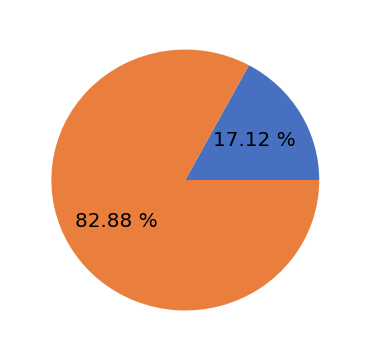

Initialized


Minibatch loss at step 0: 10,638.9; Minibatch accuracy: 8.6%; Validation accuracy: 11.1%
Minibatch loss at step 500: 11,097.3; Minibatch accuracy: 10.2%; Validation accuracy: 11.2%
Minibatch loss at step 1000: 11,812.0; Minibatch accuracy: 7.8%; Validation accuracy: 11.5%
Minibatch loss at step 1500: 10,199.8; Minibatch accuracy: 10.2%; Validation accuracy: 11.6%
Minibatch loss at step 2000: 10,369.6; Minibatch accuracy: 8.6%; Validation accuracy: 11.6%
Minibatch loss at step 2500: 10,433.9; Minibatch accuracy: 10.9%; Validation accuracy: 11.6%
Test accuracy: 12.3%


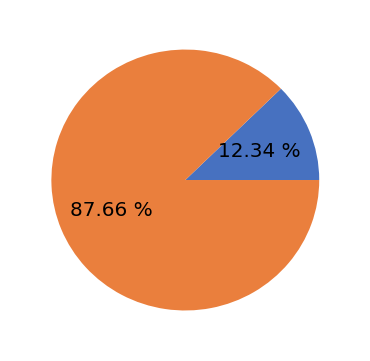

Initialized


Minibatch loss at step 0: 11,362.3; Minibatch accuracy: 11.7%; Validation accuracy: 11.8%
Minibatch loss at step 500: 10,874.7; Minibatch accuracy: 12.5%; Validation accuracy: 12.2%
Minibatch loss at step 1000: 9,046.6; Minibatch accuracy: 9.4%; Validation accuracy: 12.6%
Minibatch loss at step 1500: 10,256.9; Minibatch accuracy: 13.3%; Validation accuracy: 12.9%
Minibatch loss at step 2000: 10,029.1; Minibatch accuracy: 14.8%; Validation accuracy: 13.0%
Minibatch loss at step 2500: 9,799.6; Minibatch accuracy: 8.6%; Validation accuracy: 13.1%
Test accuracy: 13.6%


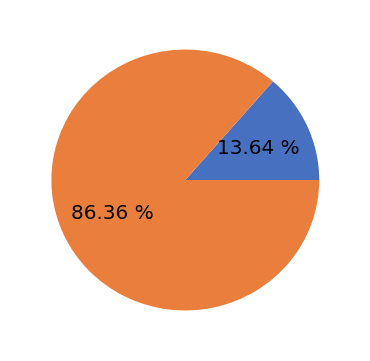

Initialized


Minibatch loss at step 0: 11,283.8; Minibatch accuracy: 8.6%; Validation accuracy: 11.8%
Minibatch loss at step 500: 11,079.8; Minibatch accuracy: 17.2%; Validation accuracy: 12.3%
Minibatch loss at step 1000: 11,345.9; Minibatch accuracy: 11.7%; Validation accuracy: 12.6%
Minibatch loss at step 1500: 10,054.1; Minibatch accuracy: 14.1%; Validation accuracy: 12.8%
Minibatch loss at step 2000: 10,210.2; Minibatch accuracy: 11.7%; Validation accuracy: 12.8%
Minibatch loss at step 2500: 10,559.1; Minibatch accuracy: 12.5%; Validation accuracy: 12.9%
Test accuracy: 13.5%


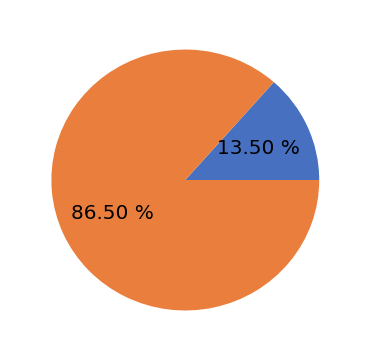

Initialized


Minibatch loss at step 0: 9,694.2; Minibatch accuracy: 12.5%; Validation accuracy: 13.2%
Minibatch loss at step 500: 10,838.6; Minibatch accuracy: 10.9%; Validation accuracy: 13.7%
Minibatch loss at step 1000: 10,044.4; Minibatch accuracy: 9.4%; Validation accuracy: 14.1%
Minibatch loss at step 1500: 9,371.0; Minibatch accuracy: 15.6%; Validation accuracy: 14.4%
Minibatch loss at step 2000: 10,438.6; Minibatch accuracy: 13.3%; Validation accuracy: 14.6%
Minibatch loss at step 2500: 9,759.8; Minibatch accuracy: 10.2%; Validation accuracy: 14.8%
Test accuracy: 14.6%


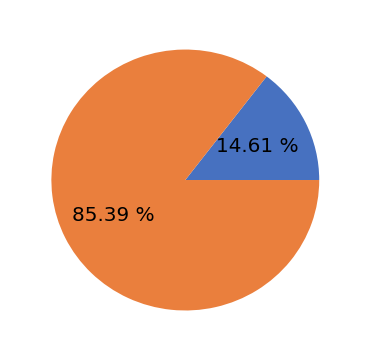

Initialized


Minibatch loss at step 0: 10,974.4; Minibatch accuracy: 9.4%; Validation accuracy: 9.4%
Minibatch loss at step 500: 9,772.3; Minibatch accuracy: 10.9%; Validation accuracy: 10.0%
Minibatch loss at step 1000: 9,998.2; Minibatch accuracy: 10.9%; Validation accuracy: 10.5%
Minibatch loss at step 1500: 9,205.0; Minibatch accuracy: 10.9%; Validation accuracy: 11.1%
Minibatch loss at step 2000: 9,811.6; Minibatch accuracy: 9.4%; Validation accuracy: 11.3%
Minibatch loss at step 2500: 9,378.5; Minibatch accuracy: 17.2%; Validation accuracy: 11.5%
Test accuracy: 12.0%


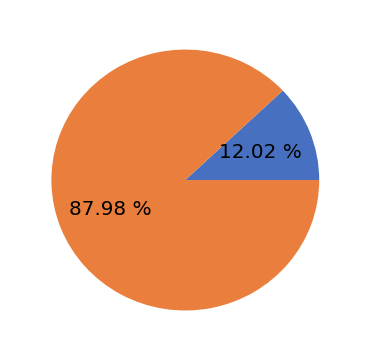

Initialized


Minibatch loss at step 0: 12,085.4; Minibatch accuracy: 12.5%; Validation accuracy: 11.8%
Minibatch loss at step 500: 11,194.5; Minibatch accuracy: 12.5%; Validation accuracy: 12.0%
Minibatch loss at step 1000: 11,931.2; Minibatch accuracy: 10.2%; Validation accuracy: 12.3%
Minibatch loss at step 1500: 10,541.9; Minibatch accuracy: 8.6%; Validation accuracy: 12.5%
Minibatch loss at step 2000: 10,917.4; Minibatch accuracy: 14.1%; Validation accuracy: 12.7%
Minibatch loss at step 2500: 10,660.4; Minibatch accuracy: 12.5%; Validation accuracy: 12.7%
Test accuracy: 12.6%


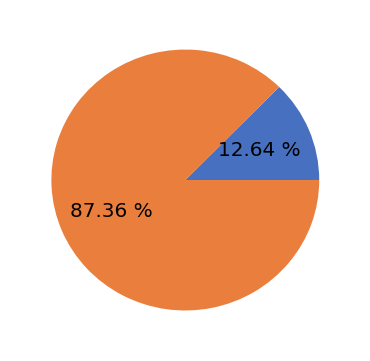

Initialized


Minibatch loss at step 0: 11,523.2; Minibatch accuracy: 7.0%; Validation accuracy: 6.0%
Minibatch loss at step 500: 10,815.7; Minibatch accuracy: 7.0%; Validation accuracy: 6.5%
Minibatch loss at step 1000: 11,310.9; Minibatch accuracy: 8.6%; Validation accuracy: 6.9%
Minibatch loss at step 1500: 10,148.4; Minibatch accuracy: 10.2%; Validation accuracy: 7.3%
Minibatch loss at step 2000: 10,440.1; Minibatch accuracy: 9.4%; Validation accuracy: 7.5%
Minibatch loss at step 2500: 10,988.6; Minibatch accuracy: 7.8%; Validation accuracy: 7.7%
Test accuracy: 7.7%


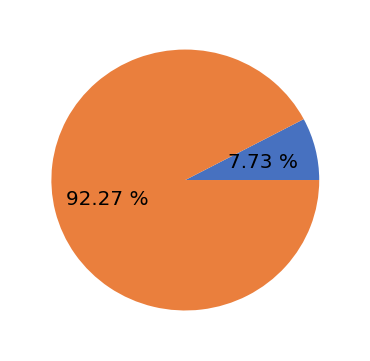

Initialized


Minibatch loss at step 0: 11,447.2; Minibatch accuracy: 11.7%; Validation accuracy: 6.9%
Minibatch loss at step 500: 10,815.4; Minibatch accuracy: 6.2%; Validation accuracy: 7.5%
Minibatch loss at step 1000: 11,055.3; Minibatch accuracy: 9.4%; Validation accuracy: 8.0%
Minibatch loss at step 1500: 10,961.0; Minibatch accuracy: 10.2%; Validation accuracy: 8.4%
Minibatch loss at step 2000: 10,761.7; Minibatch accuracy: 3.9%; Validation accuracy: 8.6%
Minibatch loss at step 2500: 10,828.5; Minibatch accuracy: 8.6%; Validation accuracy: 8.7%
Test accuracy: 9.2%


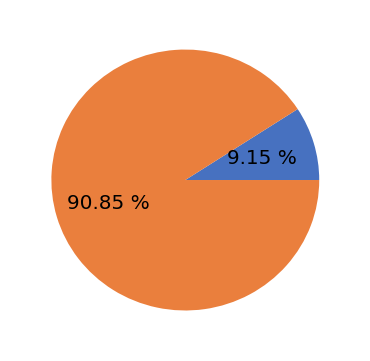

Initialized


Minibatch loss at step 0: 9,980.8; Minibatch accuracy: 8.6%; Validation accuracy: 9.7%
Minibatch loss at step 500: 10,329.4; Minibatch accuracy: 7.8%; Validation accuracy: 10.6%
Minibatch loss at step 1000: 9,771.1; Minibatch accuracy: 10.2%; Validation accuracy: 11.2%
Minibatch loss at step 1500: 10,200.8; Minibatch accuracy: 9.4%; Validation accuracy: 11.5%
Minibatch loss at step 2000: 9,954.1; Minibatch accuracy: 9.4%; Validation accuracy: 11.7%
Minibatch loss at step 2500: 9,497.4; Minibatch accuracy: 10.9%; Validation accuracy: 11.9%
Test accuracy: 12.6%


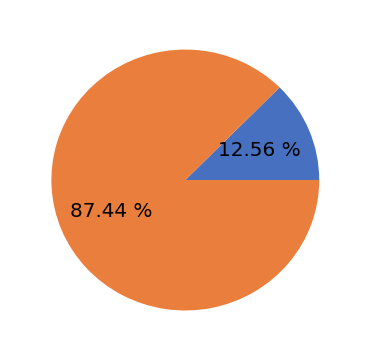

Initialized


Minibatch loss at step 0: 10,348.9; Minibatch accuracy: 11.7%; Validation accuracy: 9.4%
Minibatch loss at step 500: 9,814.2; Minibatch accuracy: 14.1%; Validation accuracy: 10.1%
Minibatch loss at step 1000: 9,481.6; Minibatch accuracy: 11.7%; Validation accuracy: 10.7%
Minibatch loss at step 1500: 9,348.1; Minibatch accuracy: 11.7%; Validation accuracy: 11.3%
Minibatch loss at step 2000: 9,414.1; Minibatch accuracy: 9.4%; Validation accuracy: 11.8%
Minibatch loss at step 2500: 9,289.6; Minibatch accuracy: 10.9%; Validation accuracy: 12.1%
Test accuracy: 12.8%


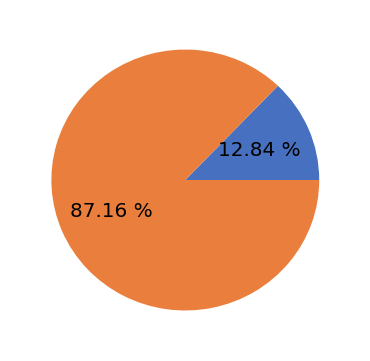

Initialized


Minibatch loss at step 0: 11,651.0; Minibatch accuracy: 7.0%; Validation accuracy: 8.5%
Minibatch loss at step 500: 10,903.9; Minibatch accuracy: 9.4%; Validation accuracy: 9.3%
Minibatch loss at step 1000: 11,121.0; Minibatch accuracy: 7.8%; Validation accuracy: 9.7%
Minibatch loss at step 1500: 10,100.9; Minibatch accuracy: 9.4%; Validation accuracy: 10.1%
Minibatch loss at step 2000: 9,223.3; Minibatch accuracy: 12.5%; Validation accuracy: 10.4%
Minibatch loss at step 2500: 9,828.6; Minibatch accuracy: 10.2%; Validation accuracy: 10.6%
Test accuracy: 10.9%


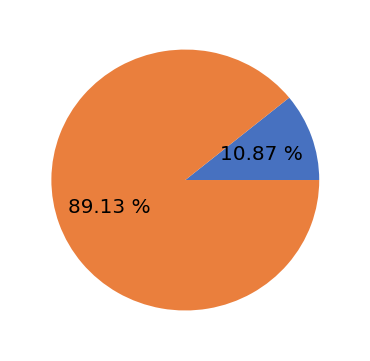

Initialized


Minibatch loss at step 0: 11,583.0; Minibatch accuracy: 9.4%; Validation accuracy: 8.9%
Minibatch loss at step 500: 10,644.8; Minibatch accuracy: 10.2%; Validation accuracy: 9.2%
Minibatch loss at step 1000: 10,175.8; Minibatch accuracy: 9.4%; Validation accuracy: 9.5%
Minibatch loss at step 1500: 9,976.9; Minibatch accuracy: 15.6%; Validation accuracy: 9.9%
Minibatch loss at step 2000: 11,896.4; Minibatch accuracy: 7.8%; Validation accuracy: 10.1%
Minibatch loss at step 2500: 9,851.7; Minibatch accuracy: 12.5%; Validation accuracy: 10.4%
Test accuracy: 10.9%


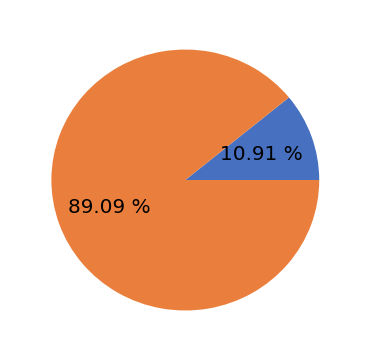

Initialized


Minibatch loss at step 0: 10,809.0; Minibatch accuracy: 13.3%; Validation accuracy: 13.4%
Minibatch loss at step 500: 9,933.5; Minibatch accuracy: 12.5%; Validation accuracy: 14.3%
Minibatch loss at step 1000: 8,830.7; Minibatch accuracy: 14.8%; Validation accuracy: 15.3%
Minibatch loss at step 1500: 8,669.6; Minibatch accuracy: 18.0%; Validation accuracy: 16.7%
Minibatch loss at step 2000: 7,956.4; Minibatch accuracy: 18.8%; Validation accuracy: 17.7%
Minibatch loss at step 2500: 8,292.2; Minibatch accuracy: 18.0%; Validation accuracy: 18.2%
Test accuracy: 19.5%


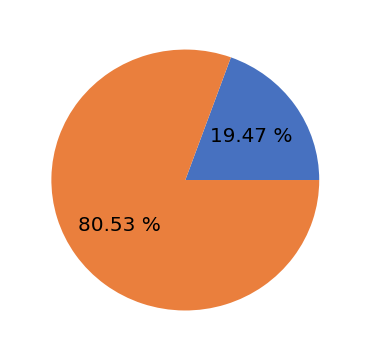

Initialized


Minibatch loss at step 0: 11,064.7; Minibatch accuracy: 6.2%; Validation accuracy: 8.3%
Minibatch loss at step 500: 10,886.4; Minibatch accuracy: 7.8%; Validation accuracy: 9.1%
Minibatch loss at step 1000: 10,423.3; Minibatch accuracy: 7.0%; Validation accuracy: 9.8%
Minibatch loss at step 1500: 10,719.6; Minibatch accuracy: 7.0%; Validation accuracy: 10.2%
Minibatch loss at step 2000: 8,602.8; Minibatch accuracy: 12.5%; Validation accuracy: 10.7%
Minibatch loss at step 2500: 9,625.6; Minibatch accuracy: 10.2%; Validation accuracy: 11.0%
Test accuracy: 11.4%


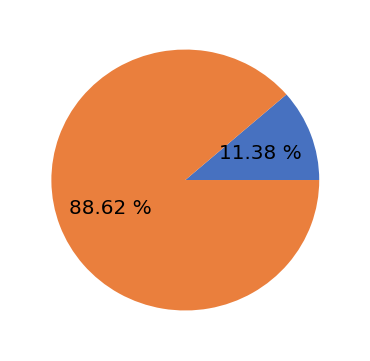

Initialized


Minibatch loss at step 0: 10,639.6; Minibatch accuracy: 12.5%; Validation accuracy: 10.8%
Minibatch loss at step 500: 10,528.3; Minibatch accuracy: 7.8%; Validation accuracy: 12.7%
Minibatch loss at step 1000: 9,551.2; Minibatch accuracy: 13.3%; Validation accuracy: 14.0%
Minibatch loss at step 1500: 9,594.9; Minibatch accuracy: 13.3%; Validation accuracy: 14.8%
Minibatch loss at step 2000: 8,886.2; Minibatch accuracy: 14.8%; Validation accuracy: 15.5%
Minibatch loss at step 2500: 8,702.1; Minibatch accuracy: 10.2%; Validation accuracy: 16.1%
Test accuracy: 18.0%


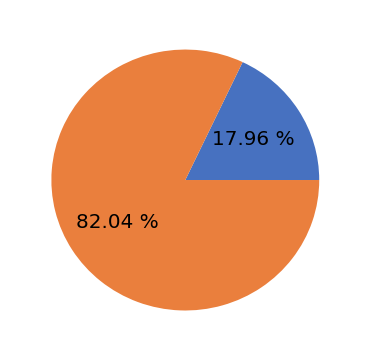

Initialized


Minibatch loss at step 0: 10,332.2; Minibatch accuracy: 12.5%; Validation accuracy: 16.9%
Minibatch loss at step 500: 10,405.4; Minibatch accuracy: 13.3%; Validation accuracy: 18.2%
Minibatch loss at step 1000: 8,468.6; Minibatch accuracy: 16.4%; Validation accuracy: 19.2%
Minibatch loss at step 1500: 9,961.4; Minibatch accuracy: 14.1%; Validation accuracy: 19.7%
Minibatch loss at step 2000: 8,554.9; Minibatch accuracy: 17.2%; Validation accuracy: 20.4%
Minibatch loss at step 2500: 8,823.8; Minibatch accuracy: 17.2%; Validation accuracy: 20.8%
Test accuracy: 22.7%


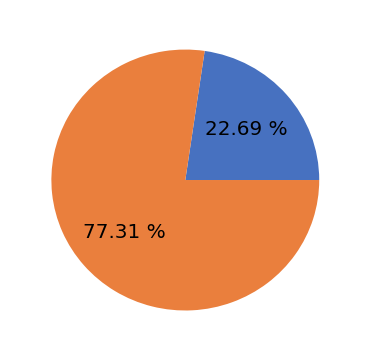

Initialized


Minibatch loss at step 0: 11,019.7; Minibatch accuracy: 11.7%; Validation accuracy: 16.5%
Minibatch loss at step 500: 9,212.0; Minibatch accuracy: 16.4%; Validation accuracy: 17.6%
Minibatch loss at step 1000: 8,899.4; Minibatch accuracy: 14.1%; Validation accuracy: 18.4%
Minibatch loss at step 1500: 8,579.8; Minibatch accuracy: 18.0%; Validation accuracy: 19.2%
Minibatch loss at step 2000: 8,738.1; Minibatch accuracy: 11.7%; Validation accuracy: 19.9%
Minibatch loss at step 2500: 7,218.7; Minibatch accuracy: 19.5%; Validation accuracy: 20.4%
Test accuracy: 22.0%


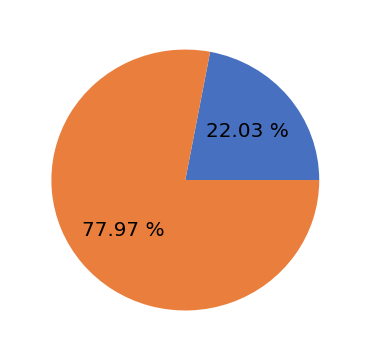

Initialized


Minibatch loss at step 0: 11,591.8; Minibatch accuracy: 14.1%; Validation accuracy: 6.8%
Minibatch loss at step 500: 11,387.7; Minibatch accuracy: 7.8%; Validation accuracy: 8.6%
Minibatch loss at step 1000: 10,735.9; Minibatch accuracy: 10.2%; Validation accuracy: 10.2%
Minibatch loss at step 1500: 9,879.0; Minibatch accuracy: 10.2%; Validation accuracy: 11.6%
Minibatch loss at step 2000: 10,059.9; Minibatch accuracy: 7.0%; Validation accuracy: 12.4%
Minibatch loss at step 2500: 9,304.0; Minibatch accuracy: 11.7%; Validation accuracy: 13.0%
Test accuracy: 14.3%


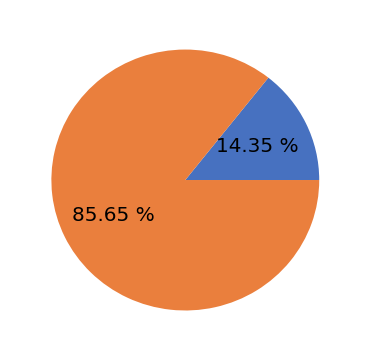

Initialized


Minibatch loss at step 0: 10,470.8; Minibatch accuracy: 3.1%; Validation accuracy: 9.9%
Minibatch loss at step 500: 9,478.2; Minibatch accuracy: 10.9%; Validation accuracy: 11.7%
Minibatch loss at step 1000: 8,818.3; Minibatch accuracy: 14.8%; Validation accuracy: 13.4%
Minibatch loss at step 1500: 9,633.5; Minibatch accuracy: 12.5%; Validation accuracy: 14.7%
Minibatch loss at step 2000: 8,751.4; Minibatch accuracy: 11.7%; Validation accuracy: 15.5%
Minibatch loss at step 2500: 7,803.2; Minibatch accuracy: 14.1%; Validation accuracy: 16.2%
Test accuracy: 18.1%


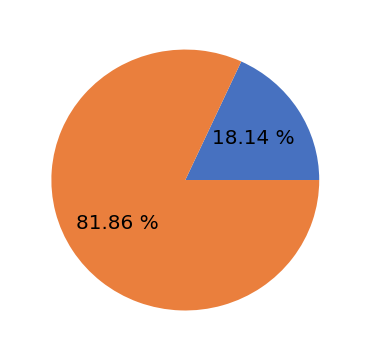

Initialized


Minibatch loss at step 0: 11,316.3; Minibatch accuracy: 7.0%; Validation accuracy: 6.1%
Minibatch loss at step 500: 9,647.9; Minibatch accuracy: 12.5%; Validation accuracy: 8.6%
Minibatch loss at step 1000: 9,287.4; Minibatch accuracy: 8.6%; Validation accuracy: 10.5%
Minibatch loss at step 1500: 8,220.8; Minibatch accuracy: 21.1%; Validation accuracy: 12.0%
Minibatch loss at step 2000: 9,598.2; Minibatch accuracy: 11.7%; Validation accuracy: 13.1%
Minibatch loss at step 2500: 9,078.4; Minibatch accuracy: 11.7%; Validation accuracy: 13.9%
Test accuracy: 16.7%


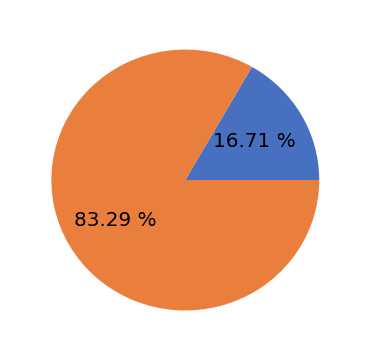

Initialized


Minibatch loss at step 0: 12,127.5; Minibatch accuracy: 8.6%; Validation accuracy: 11.3%
Minibatch loss at step 500: 8,171.6; Minibatch accuracy: 16.4%; Validation accuracy: 14.6%
Minibatch loss at step 1000: 9,429.7; Minibatch accuracy: 8.6%; Validation accuracy: 17.4%
Minibatch loss at step 1500: 8,004.2; Minibatch accuracy: 14.8%; Validation accuracy: 19.4%
Minibatch loss at step 2000: 8,022.2; Minibatch accuracy: 21.1%; Validation accuracy: 21.0%
Minibatch loss at step 2500: 7,439.2; Minibatch accuracy: 19.5%; Validation accuracy: 22.2%
Test accuracy: 25.4%


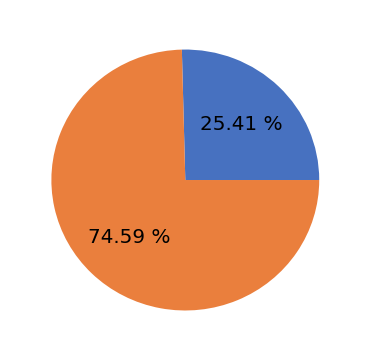

Initialized


Minibatch loss at step 0: 9,693.0; Minibatch accuracy: 16.4%; Validation accuracy: 10.8%
Minibatch loss at step 500: 9,880.2; Minibatch accuracy: 14.1%; Validation accuracy: 15.9%
Minibatch loss at step 1000: 7,806.2; Minibatch accuracy: 18.8%; Validation accuracy: 20.3%
Minibatch loss at step 1500: 8,476.4; Minibatch accuracy: 15.6%; Validation accuracy: 23.2%
Minibatch loss at step 2000: 7,744.7; Minibatch accuracy: 14.8%; Validation accuracy: 24.9%
Minibatch loss at step 2500: 7,267.8; Minibatch accuracy: 14.1%; Validation accuracy: 26.1%
Test accuracy: 29.8%


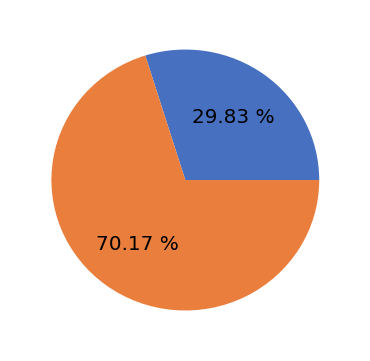

Initialized


Minibatch loss at step 0: 9,226.6; Minibatch accuracy: 14.8%; Validation accuracy: 10.0%
Minibatch loss at step 500: 8,885.2; Minibatch accuracy: 10.9%; Validation accuracy: 15.5%
Minibatch loss at step 1000: 7,708.2; Minibatch accuracy: 21.1%; Validation accuracy: 20.2%
Minibatch loss at step 1500: 7,651.7; Minibatch accuracy: 18.0%; Validation accuracy: 23.5%
Minibatch loss at step 2000: 6,647.4; Minibatch accuracy: 22.7%; Validation accuracy: 25.7%
Minibatch loss at step 2500: 7,457.0; Minibatch accuracy: 15.6%; Validation accuracy: 27.4%
Test accuracy: 33.6%


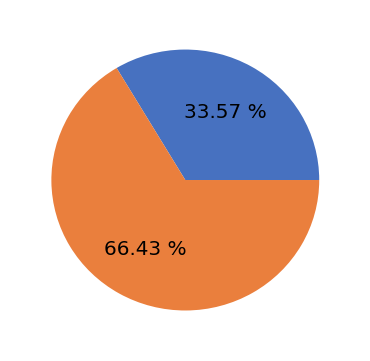

Initialized


Minibatch loss at step 0: 12,556.3; Minibatch accuracy: 8.6%; Validation accuracy: 6.5%
Minibatch loss at step 500: 9,128.1; Minibatch accuracy: 10.2%; Validation accuracy: 10.5%
Minibatch loss at step 1000: 8,561.2; Minibatch accuracy: 12.5%; Validation accuracy: 14.3%
Minibatch loss at step 1500: 7,811.4; Minibatch accuracy: 14.1%; Validation accuracy: 17.1%
Minibatch loss at step 2000: 7,233.3; Minibatch accuracy: 18.8%; Validation accuracy: 19.1%
Minibatch loss at step 2500: 8,779.2; Minibatch accuracy: 10.2%; Validation accuracy: 20.5%
Test accuracy: 23.6%


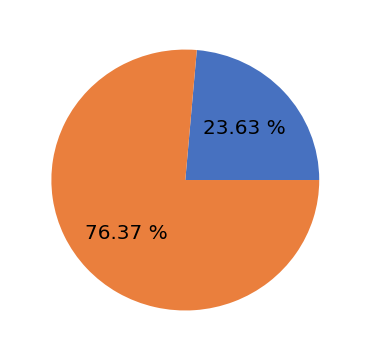

Initialized


Minibatch loss at step 0: 11,722.8; Minibatch accuracy: 13.3%; Validation accuracy: 10.2%
Minibatch loss at step 500: 8,344.9; Minibatch accuracy: 16.4%; Validation accuracy: 14.7%
Minibatch loss at step 1000: 7,285.1; Minibatch accuracy: 18.0%; Validation accuracy: 19.8%
Minibatch loss at step 1500: 7,482.5; Minibatch accuracy: 21.1%; Validation accuracy: 23.4%
Minibatch loss at step 2000: 7,955.9; Minibatch accuracy: 18.0%; Validation accuracy: 26.5%
Minibatch loss at step 2500: 6,817.2; Minibatch accuracy: 19.5%; Validation accuracy: 29.2%
Test accuracy: 33.1%


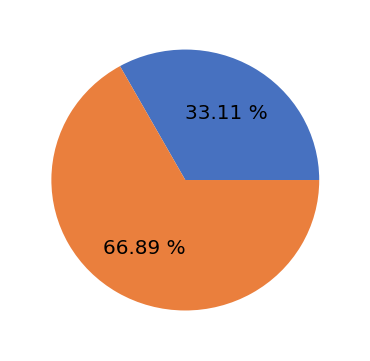

Initialized


Minibatch loss at step 0: 10,440.4; Minibatch accuracy: 11.7%; Validation accuracy: 14.7%
Minibatch loss at step 500: 8,739.9; Minibatch accuracy: 15.6%; Validation accuracy: 20.3%
Minibatch loss at step 1000: 7,901.5; Minibatch accuracy: 17.2%; Validation accuracy: 25.0%
Minibatch loss at step 1500: 7,259.6; Minibatch accuracy: 19.5%; Validation accuracy: 28.2%
Minibatch loss at step 2000: 6,956.0; Minibatch accuracy: 17.2%; Validation accuracy: 30.7%
Minibatch loss at step 2500: 6,432.5; Minibatch accuracy: 24.2%; Validation accuracy: 32.2%
Test accuracy: 37.2%


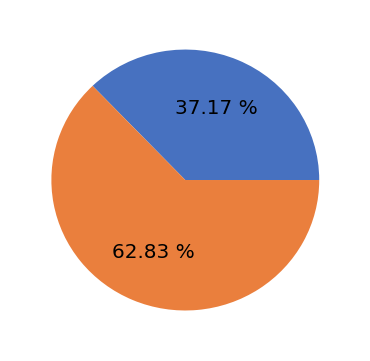

Initialized


Minibatch loss at step 0: 11,325.2; Minibatch accuracy: 7.0%; Validation accuracy: 11.5%
Minibatch loss at step 500: 8,100.8; Minibatch accuracy: 9.4%; Validation accuracy: 18.5%
Minibatch loss at step 1000: 7,755.4; Minibatch accuracy: 21.9%; Validation accuracy: 24.7%
Minibatch loss at step 1500: 5,668.0; Minibatch accuracy: 26.6%; Validation accuracy: 30.1%
Minibatch loss at step 2000: 6,549.7; Minibatch accuracy: 19.5%; Validation accuracy: 34.0%
Minibatch loss at step 2500: 6,179.8; Minibatch accuracy: 20.3%; Validation accuracy: 36.5%
Test accuracy: 42.0%


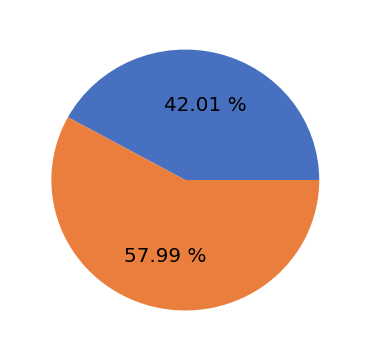

Initialized


Minibatch loss at step 0: 11,635.4; Minibatch accuracy: 11.7%; Validation accuracy: 10.9%
Minibatch loss at step 500: 8,233.5; Minibatch accuracy: 17.2%; Validation accuracy: 20.1%
Minibatch loss at step 1000: 7,084.6; Minibatch accuracy: 22.7%; Validation accuracy: 26.5%
Minibatch loss at step 1500: 6,393.2; Minibatch accuracy: 21.9%; Validation accuracy: 31.4%
Minibatch loss at step 2000: 5,111.2; Minibatch accuracy: 31.2%; Validation accuracy: 34.8%
Minibatch loss at step 2500: 5,822.8; Minibatch accuracy: 22.7%; Validation accuracy: 37.4%
Test accuracy: 44.5%


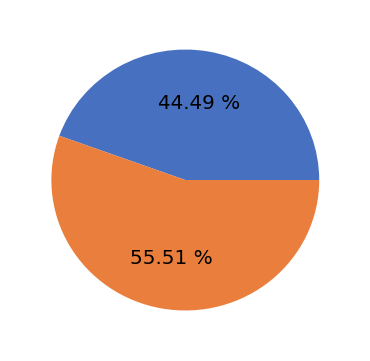

Initialized


Minibatch loss at step 0: 11,169.4; Minibatch accuracy: 11.7%; Validation accuracy: 11.7%
Minibatch loss at step 500: 9,374.4; Minibatch accuracy: 10.2%; Validation accuracy: 19.1%
Minibatch loss at step 1000: 7,808.1; Minibatch accuracy: 16.4%; Validation accuracy: 26.1%
Minibatch loss at step 1500: 6,105.7; Minibatch accuracy: 30.5%; Validation accuracy: 31.6%
Minibatch loss at step 2000: 6,571.8; Minibatch accuracy: 24.2%; Validation accuracy: 35.4%
Minibatch loss at step 2500: 5,755.3; Minibatch accuracy: 28.1%; Validation accuracy: 37.8%
Test accuracy: 43.0%


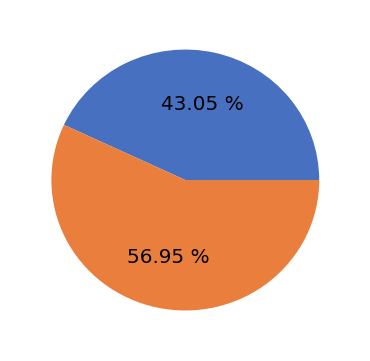

Initialized


Minibatch loss at step 0: 10,566.8; Minibatch accuracy: 9.4%; Validation accuracy: 8.4%
Minibatch loss at step 500: 7,652.3; Minibatch accuracy: 18.0%; Validation accuracy: 20.9%
Minibatch loss at step 1000: 7,490.3; Minibatch accuracy: 19.5%; Validation accuracy: 30.9%
Minibatch loss at step 1500: 6,455.3; Minibatch accuracy: 23.4%; Validation accuracy: 38.0%
Minibatch loss at step 2000: 5,670.5; Minibatch accuracy: 29.7%; Validation accuracy: 41.6%
Minibatch loss at step 2500: 6,691.1; Minibatch accuracy: 25.8%; Validation accuracy: 43.9%
Test accuracy: 49.4%


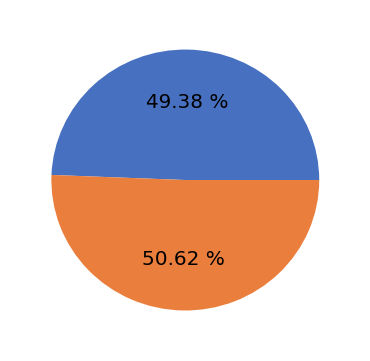

Initialized


Minibatch loss at step 0: 12,053.6; Minibatch accuracy: 8.6%; Validation accuracy: 9.6%
Minibatch loss at step 500: 7,736.4; Minibatch accuracy: 14.1%; Validation accuracy: 19.5%
Minibatch loss at step 1000: 6,947.3; Minibatch accuracy: 18.0%; Validation accuracy: 29.6%
Minibatch loss at step 1500: 6,523.4; Minibatch accuracy: 24.2%; Validation accuracy: 37.9%
Minibatch loss at step 2000: 6,492.7; Minibatch accuracy: 28.1%; Validation accuracy: 42.7%
Minibatch loss at step 2500: 5,330.5; Minibatch accuracy: 33.6%; Validation accuracy: 45.6%
Test accuracy: 52.7%


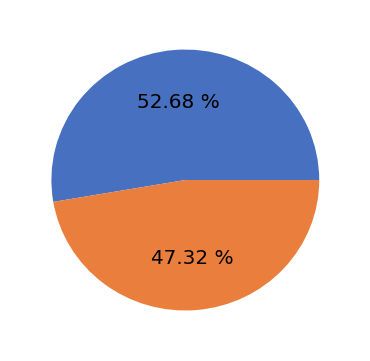

Initialized


Minibatch loss at step 0: 9,145.2; Minibatch accuracy: 14.8%; Validation accuracy: 15.5%
Minibatch loss at step 500: 6,860.4; Minibatch accuracy: 21.1%; Validation accuracy: 34.6%
Minibatch loss at step 1000: 6,246.3; Minibatch accuracy: 28.1%; Validation accuracy: 44.6%
Minibatch loss at step 1500: 5,477.5; Minibatch accuracy: 29.7%; Validation accuracy: 51.3%
Minibatch loss at step 2000: 5,438.4; Minibatch accuracy: 32.8%; Validation accuracy: 54.6%
Minibatch loss at step 2500: 5,541.1; Minibatch accuracy: 32.0%; Validation accuracy: 56.3%
Test accuracy: 62.8%


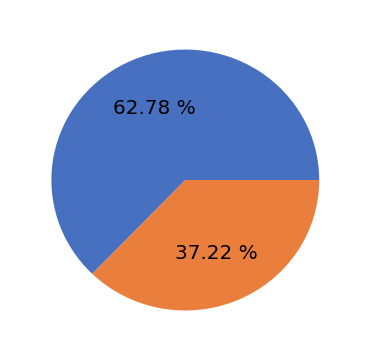

Initialized


Minibatch loss at step 0: 11,548.2; Minibatch accuracy: 14.8%; Validation accuracy: 8.7%
Minibatch loss at step 500: 8,125.4; Minibatch accuracy: 16.4%; Validation accuracy: 27.1%
Minibatch loss at step 1000: 5,365.3; Minibatch accuracy: 28.1%; Validation accuracy: 41.9%
Minibatch loss at step 1500: 6,025.0; Minibatch accuracy: 26.6%; Validation accuracy: 48.8%
Minibatch loss at step 2000: 5,099.9; Minibatch accuracy: 33.6%; Validation accuracy: 53.0%
Minibatch loss at step 2500: 5,023.4; Minibatch accuracy: 31.2%; Validation accuracy: 55.5%
Test accuracy: 64.1%


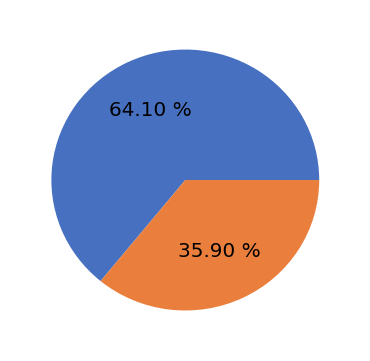

Initialized


Minibatch loss at step 0: 11,362.1; Minibatch accuracy: 9.4%; Validation accuracy: 11.1%
Minibatch loss at step 500: 8,267.3; Minibatch accuracy: 19.5%; Validation accuracy: 26.7%
Minibatch loss at step 1000: 6,532.6; Minibatch accuracy: 21.1%; Validation accuracy: 40.0%
Minibatch loss at step 1500: 5,956.8; Minibatch accuracy: 33.6%; Validation accuracy: 47.4%
Minibatch loss at step 2000: 5,165.8; Minibatch accuracy: 32.8%; Validation accuracy: 51.1%
Minibatch loss at step 2500: 5,185.3; Minibatch accuracy: 34.4%; Validation accuracy: 53.4%
Test accuracy: 60.7%


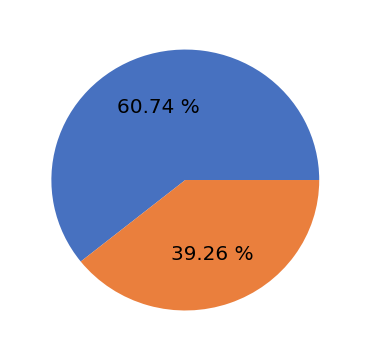

Initialized


Minibatch loss at step 0: 11,210.3; Minibatch accuracy: 9.4%; Validation accuracy: 9.9%
Minibatch loss at step 500: 7,960.3; Minibatch accuracy: 18.8%; Validation accuracy: 29.1%
Minibatch loss at step 1000: 4,851.8; Minibatch accuracy: 30.5%; Validation accuracy: 44.1%
Minibatch loss at step 1500: 5,136.7; Minibatch accuracy: 33.6%; Validation accuracy: 51.3%
Minibatch loss at step 2000: 6,504.4; Minibatch accuracy: 22.7%; Validation accuracy: 55.5%
Minibatch loss at step 2500: 4,954.5; Minibatch accuracy: 38.3%; Validation accuracy: 57.8%
Test accuracy: 65.5%


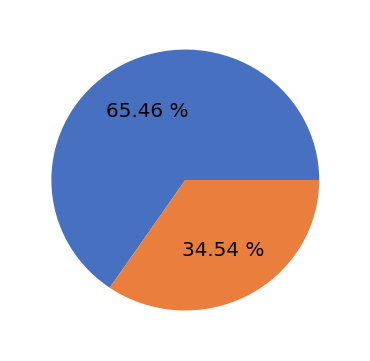

Initialized


Minibatch loss at step 0: 11,751.3; Minibatch accuracy: 7.8%; Validation accuracy: 10.5%
Minibatch loss at step 500: 7,206.8; Minibatch accuracy: 18.8%; Validation accuracy: 32.8%
Minibatch loss at step 1000: 5,999.4; Minibatch accuracy: 32.8%; Validation accuracy: 50.4%
Minibatch loss at step 1500: 5,330.1; Minibatch accuracy: 32.0%; Validation accuracy: 56.9%
Minibatch loss at step 2000: 4,588.5; Minibatch accuracy: 41.4%; Validation accuracy: 59.8%
Minibatch loss at step 2500: 4,674.6; Minibatch accuracy: 38.3%; Validation accuracy: 61.4%
Test accuracy: 70.2%


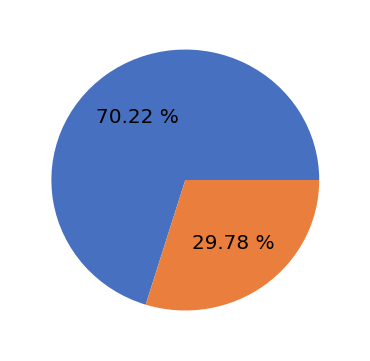

Initialized


Minibatch loss at step 0: 11,189.8; Minibatch accuracy: 7.8%; Validation accuracy: 10.0%
Minibatch loss at step 500: 6,681.2; Minibatch accuracy: 25.0%; Validation accuracy: 40.7%
Minibatch loss at step 1000: 5,165.7; Minibatch accuracy: 34.4%; Validation accuracy: 53.5%
Minibatch loss at step 1500: 4,750.4; Minibatch accuracy: 35.9%; Validation accuracy: 58.8%
Minibatch loss at step 2000: 4,763.1; Minibatch accuracy: 41.4%; Validation accuracy: 61.5%
Minibatch loss at step 2500: 5,081.3; Minibatch accuracy: 39.1%; Validation accuracy: 63.3%
Test accuracy: 71.9%


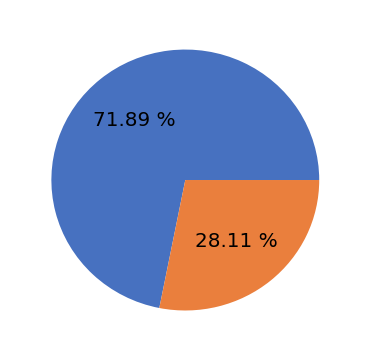

In [54]:
# Grid search params

test_accuracies = []
learning_rate_inits = np.logspace(start=-10,stop=-5, num=100)

for learning_rate_init_probe in tqdm.tqdm_notebook(learning_rate_inits):
    # params
    batch_size = 128
    dropout_keep_prob = 0.5
#    learning_rate_init = 0.001
    decay_steps = 1000
    decay_rate = 0.5
    beta_1_value = 1e-3
    beta_2_value = 1e-3
    beta_3_value = 1e-3

    best_possible_graph = tf.Graph()
    with best_possible_graph.as_default():
        # Input data
        # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        # train data: rows × columns; placeholder so can do SGD
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(
            batch_size, num_labels))  # train labels: rows × 1

        tf_valid_dataset = tf.constant(valid_dataset)  # validation data
        tf_test_dataset = tf.constant(test_dataset)

        ############################## Variables. (Parameters); initialize.
        # not reducing dimensionality, so same number of rows as columns; initialize as normal

        # W₁: (number_of_pixels_per_image × number_of_pixels_per_image)
        # b₁: (number_of_pixels_per_image × 1)    
        weights_layer_one = tf.Variable(tf.truncated_normal(
            [image_size * image_size, image_size * image_size]))
        # one bias per feature; initialize at zero
        biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

        # W₂: (number_of_pixels_per_image × number_of_pixels_per_image)
        # b₂: (number_of_pixels_per_image × 1)
        weights_layer_three = tf.Variable(
            tf.truncated_normal([image_size * image_size, image_size * image_size]))
        biases_layer_three = tf.Variable(tf.zeros([image_size * image_size]))

        # W₃: (number_of_pixels_per_image × num_labels(=10))
        # b₃: (num_labels(=10) × 1)
        weights_layer_four = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]))
        biases_layer_four = tf.Variable(tf.zeros([num_labels]))

        ############################## Training computation (layer specification using variables above and other methods).

        #  layer 1 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_one_output_tensor = tf.matmul(
            tf_train_dataset, weights_layer_one) + biases_layer_one 

        # additional dropout/ RELU layer
        # layer 2 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(
            layer_one_output_tensor, keep_prob=dropout_keep_prob)) 

        #  additional regular layer
        # layer 3 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_three_output_tensor = tf.matmul(layer_two_output_tensor, weights_layer_three) + biases_layer_three  

        # output:  (n_train × number_of_pixels_per_image)  → (n_train × num_labels(=10))
        logits = tf.matmul(layer_three_output_tensor,
                           weights_layer_four) + biases_layer_four

        ############################## Objective function
        # Regularization of *weights*: objective + β₁‖W₁‖₂ + β₂‖W₂‖₂ + β₃‖W₃‖₂
        beta_1 = tf.constant([beta_1_value])
        beta_2 = tf.constant([beta_2_value])
        beta_3 = tf.constant([beta_3_value])
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                            tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three))) + tf.multiply(beta_3, tf.reduce_mean(tf.nn.l2_loss(weights_layer_four)))

        ############################## Optimizer
        global_step = tf.Variable(0)  # initialize as 1 × 1 vector (scalar) = 0; # a scalar Tensor of the same type as `learning_rate` (in this case, float64)

        learning_rate = tf.train.exponential_decay(learning_rate=learning_rate_init_probe, 
                                                   global_step=global_step, 
                                                   decay_steps=decay_steps,
                                                   decay_rate=decay_rate, 
                                                   staircase=False)  

        # Exponential decay: decayed_learning_rate = learning_rate *
        #                         decay_rate ^ (global_step / decay_steps)
        # if staircase=True, decay steps is how many steps before decay kicks in. Higher value ⇒ lower rate of decay; otherwise, this is done at every step

        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
            loss=loss, global_step=global_step)  # will global_step be updated?

        #     optimzer = tf.train.AdamOptimizer().minimize(loss=loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)
        test_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)

        ########################################################################################################################################################################################################
        ############################################################################################## Run Graph ###############################################################################################
        ########################################################################################################################################################################################################

        num_steps = 3000
        num_batches = (train_labels.shape[0] - batch_size)  # Max number of possible batches: all possible starting positions in the training set


        with tf.Session(graph=best_possible_graph) as session:
            tf.global_variables_initializer().run()
            print("Initialized")
            for step in tqdm.tqdm_notebook(range(num_steps)):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size)  % num_batches 

                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]

                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
                # thus, batch_data and batch_labels are subsets of this np.array. 
                feed_dict = {tf_train_dataset: batch_data,
                             tf_train_labels: batch_labels}


                _, l, predictions = session.run(
                    [optimizer, loss, train_prediction], feed_dict=feed_dict)

                if (step % 500 == 0):
                    print("Minibatch loss at step {}: {:,.1f}".format(step, l[0]), end='; ')
                    print("Minibatch accuracy: %.1f%%" %
                          accuracy(predictions, batch_labels), end='; ' )
                    print("Validation accuracy: %.1f%%" % accuracy(
                        valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(
                test_prediction.eval(), test_labels))     
            isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))
            test_accuracies += [accuracy(test_prediction.eval(), test_labels)]



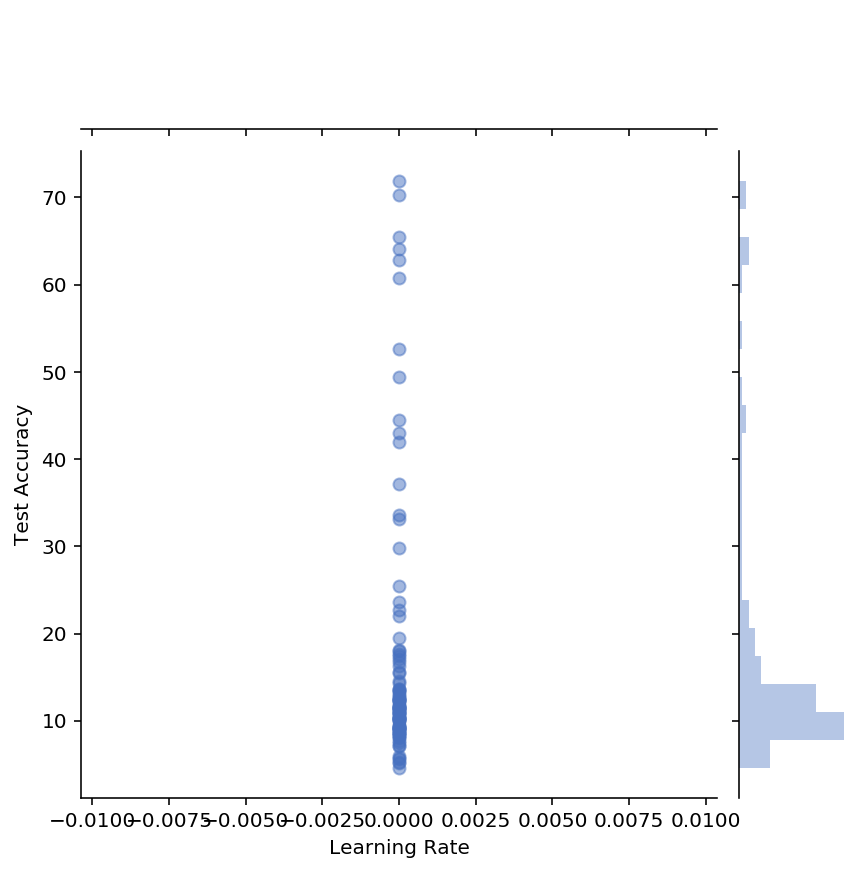

In [55]:
sns.jointplot(learning_rate_inits, test_accuracies, alpha=0.5).set_axis_labels("Learning Rate", "Test Accuracy")

Hm, larger batch size doesn't necessarily matter for accuracy after a certain point (has diminishing returns). However, it takes much longer. 

In [60]:
import isajosep_util

(<matplotlib.axes._subplots.ScatterDensityAxesSubplot at 0x7f477c665be0>,
 <Figure size 720x720 with 2 Axes>)

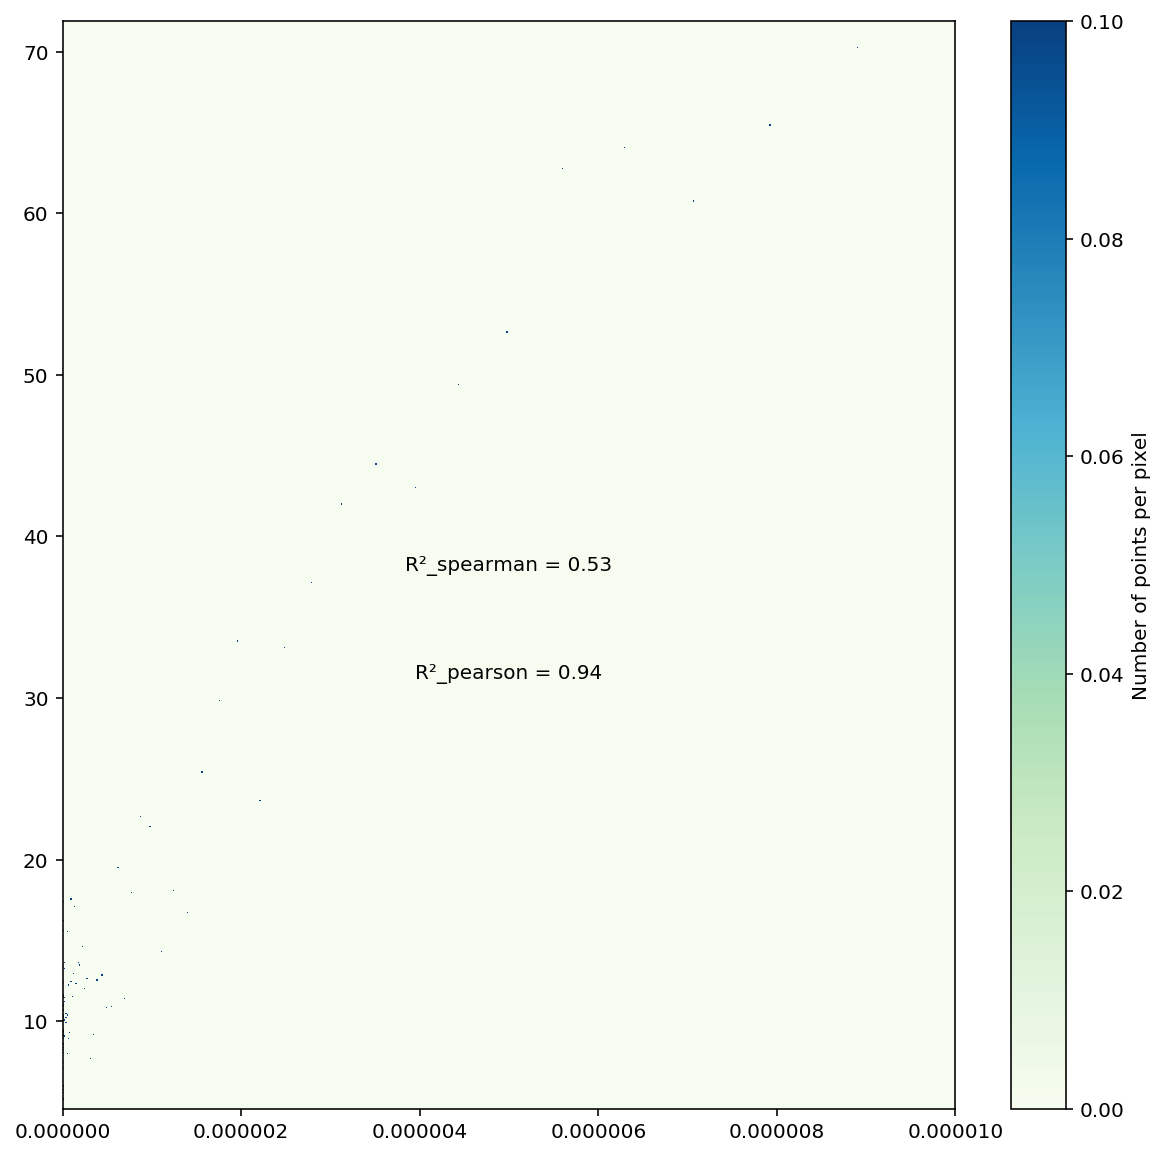

In [61]:
isajosep_util.data_frame_plotter.mpl_scatter_density_from_df(learning_rate_inits, test_accuracies)

Text(0,0.5,'test accuracy (%)')

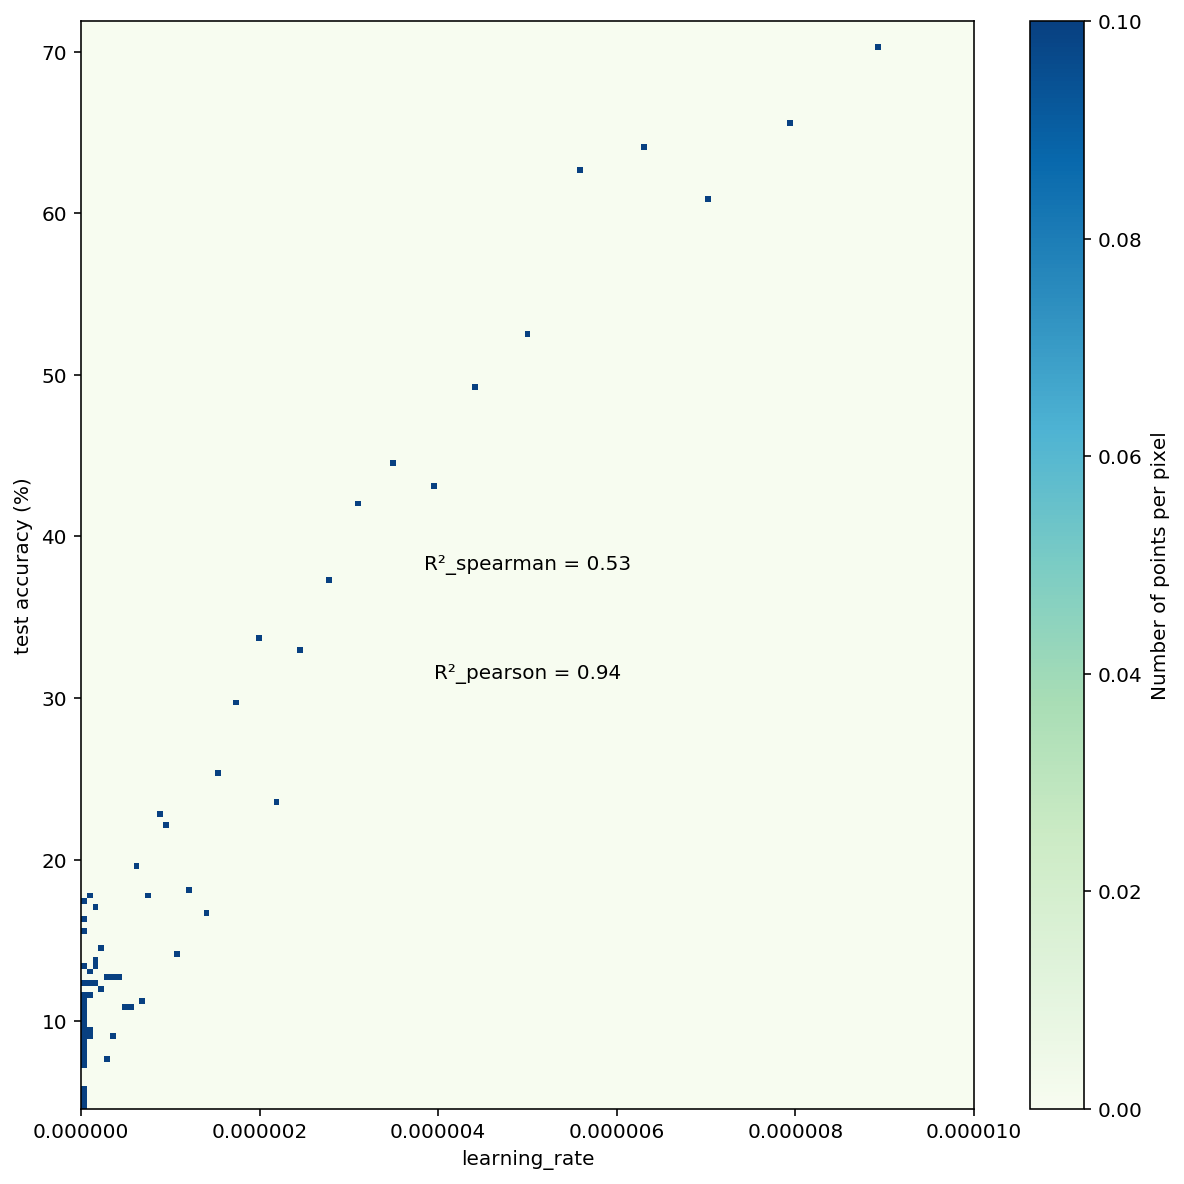

In [70]:
ax, fig = isajosep_util.data_frame_plotter.mpl_scatter_density_from_df(learning_rate_inits, test_accuracies, dpi=30)
ax.set_xlabel("learning_rate")
ax.set_ylabel("test accuracy (%)")